In [1]:
import flapjack as flap
import loica as lc
import sbol3
from sbol_utilities import component

import numpy as np
import getpass
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
user = input()
passwd = getpass.getpass()
#fj = flap.flapjack.Flapjack('localhost:8000')
fj = flap.flapjack.Flapjack('flapjack.rudge-lab.org:8000')
fj.log_in(username=user, password=passwd)

# NOR gate

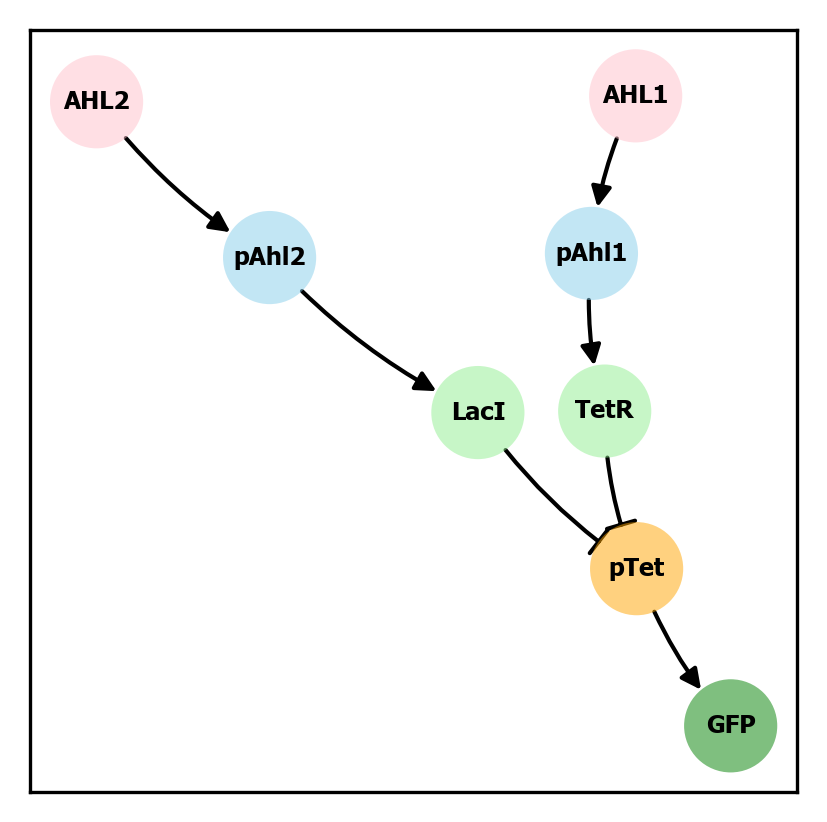

In [3]:
nor = lc.GeneticNetwork(vector=0)

ahl1 = lc.Supplement(name='AHL1')
ahl2 = lc.Supplement(name='AHL2')

tetr_reg = lc.Regulator(name='TetR', degradation_rate=0)
laci_reg = lc.Regulator(name='LacI', degradation_rate=0)
nor.add_regulator([tetr_reg, laci_reg])

gfp_rep = lc.Reporter(name='GFP', degradation_rate=0, signal_id=0 , color='green')
nor.add_reporter(gfp_rep)

ahl1_not_tetr_gfp = lc.Receiver(name='pAhl1', input=ahl1, output=[tetr_reg], alpha=[0.1, 10000], K=10, n=2)
ahl2_not_laci = lc.Receiver(name='pAhl2', input=ahl2, output=laci_reg, alpha=[0.1, 10000], K=10, n=2)
tetr_laci_nor_gfp = lc.Hill2(name='pTet', input=[tetr_reg, laci_reg], output=gfp_rep, alpha=[10000, 10000,0.1, 0.1], K=[10, 10], n=[2,2])
nor.add_operator([ahl1_not_tetr_gfp, ahl2_not_laci,tetr_laci_nor_gfp])

plt.figure(figsize=(3.3,3.3), dpi=300)
nor.draw()

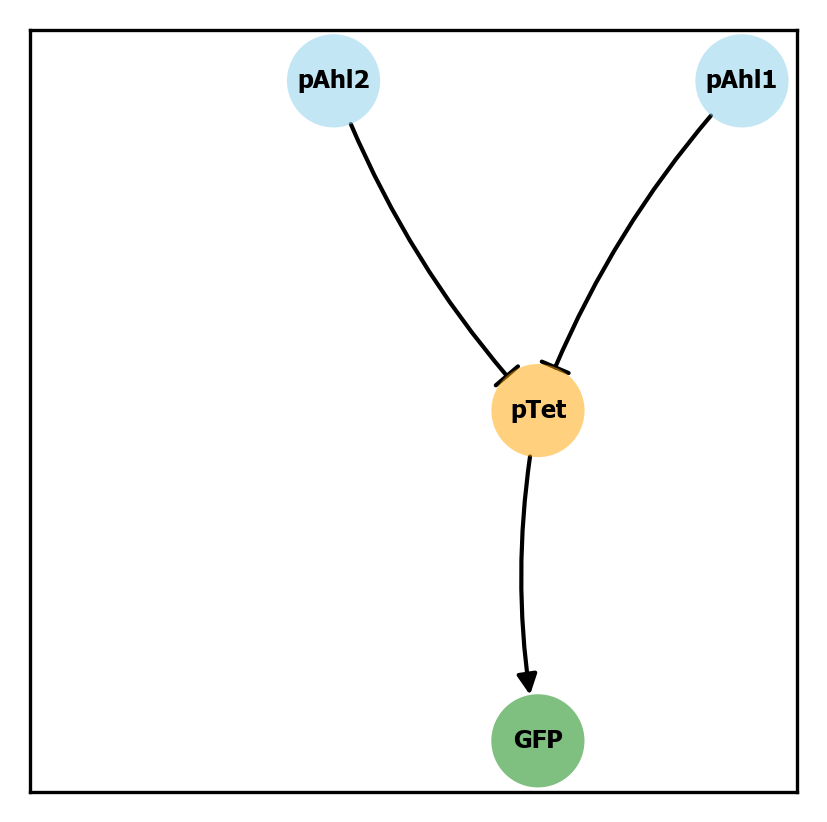

In [4]:
plt.figure(figsize=(3.3,3.3), dpi=300)
nor.draw(contracted=True)

In [5]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism('LOICA metab', biomass, growth_rate)

# Create list of samples    
samples = []
for conc1 in np.logspace(-3, 3, 12):
    for conc2 in np.logspace(-3, 3, 12):
        sample = lc.Sample(genetic_network=nor, metabolism=metab)
        # Add AHL to samples at given concentration
        sample.set_supplement(ahl1, conc1)
        sample.set_supplement(ahl2, conc2)
        samples.append(sample)

assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA ahl NOR gate',
              description='Simulated NOR gate generated by LOICA',
              biomass_signal_id=0
             )
assay.run()

100%|██████████| 100.0/100 [00:00<00:00, 148.63it/s]


# NOR gate connected to Flapjack

In [14]:

dna = fj.create('dna', name='ahl_nor_gate')

vector = fj.create('vector', name='ahl_nor_gate_plasmid', dnas=dna.id[0])   

study = fj.create('study', name='ahl_nor_study', description='Test for demonstration')

media = fj.create('media', name='Loica LB', description='Simulated loica media')

strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfps = fj.create('signal', name='SGFP', color='green', description='Simulated green fluorescent protein')

biomass_signal = fj.get('signal', name='OD')

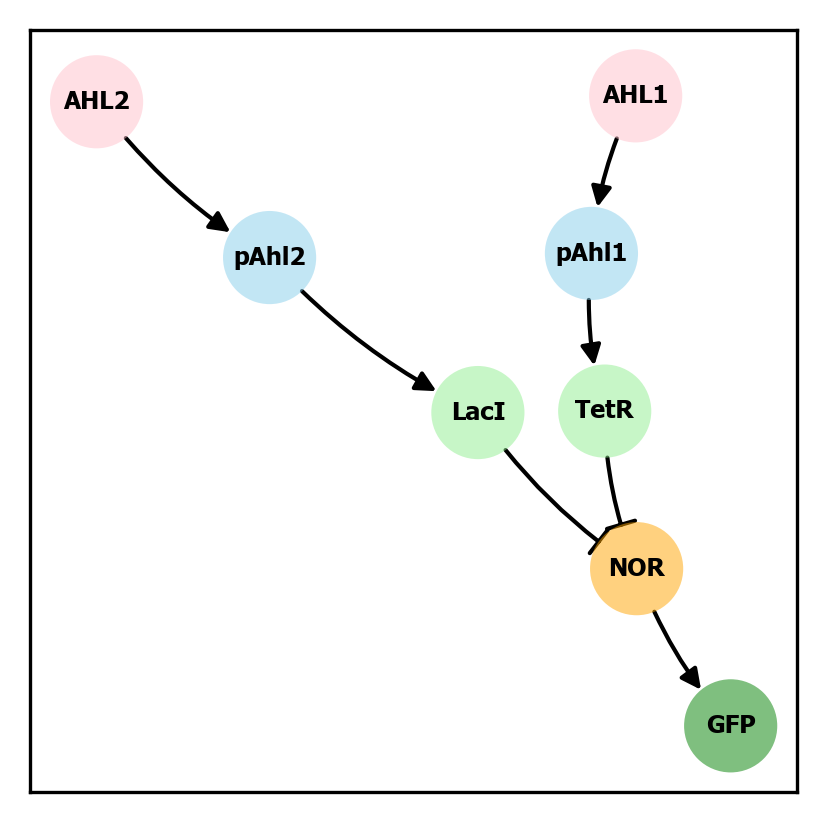

In [19]:
nor = lc.GeneticNetwork(vector=vector.id[0])

ahl1 = lc.Supplement(name='AHL1')
ahl2 = lc.Supplement(name='AHL2')

tetr_reg = lc.Regulator(name='TetR', degradation_rate=0)
laci_reg = lc.Regulator(name='LacI', degradation_rate=0)
nor.add_regulator([tetr_reg, laci_reg])

gfp_rep = lc.Reporter(name='GFP', degradation_rate=0, signal_id=gfps.id[0] , color='green')
nor.add_reporter(gfp_rep)

ahl1_not_tetr_gfp = lc.Receiver(name='pAhl1', input=ahl1, output=[tetr_reg], alpha=[0.1, 10000], K=10, n=2)
ahl2_not_laci = lc.Receiver(name='pAhl2', input=ahl2, output=laci_reg, alpha=[0.1, 10000], K=10, n=2)
tetr_laci_nor_gfp = lc.Hill2(name='NOR', input=[tetr_reg, laci_reg], output=gfp_rep, alpha=[10000, 1e-2, 1e-2, 1e-4], K=[10, 10], n=[2,2])
nor.add_operator([ahl1_not_tetr_gfp, ahl2_not_laci,tetr_laci_nor_gfp])

plt.figure(figsize=(3.3,3.3), dpi=300)
nor.draw()

In [20]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism('LOICA metab', biomass, growth_rate)

# Create list of samples    
samples = []
for conc1 in np.logspace(-3, 3, 12):
    for conc2 in np.logspace(-3, 3, 12):
        sample = lc.Sample(genetic_network=nor, metabolism=metab,
                           media=media.id[0], strain=strain.id[0])
        # Add AHL to samples at given concentration
        sample.set_supplement(ahl1, conc1)
        sample.set_supplement(ahl2, conc2)
        samples.append(sample)

assay = lc.Assay(samples, 
              n_measurements=100, 
              interval=0.25,
              name='LOICA ahl NOR gate',
              description='Simulated NOR gate generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

100%|█████████▉| 99.9999999999813/100 [01:05<00:00,  1.52it/s]   


In [21]:
assay.upload(fj, study.id[0])

  0%|          | 0/100 [00:02<?, ?it/s]


KeyError: 'results'

# Repressilator

In [22]:

dna = fj.create('dna', name='Rep_simple')

vector = fj.create('vector', name='Rep_plasmid', dnas=dna.id)   

study = fj.create('study', name='Simple_repressilator', description='Test for demonstration')

media = fj.create('media', name='Loica LB', description='Simulated loica media')

strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfps = fj.create('signal', name='SGFP', color='green', description='Simulated green fluorescent protein')

biomass_signal = fj.get('signal', name='OD')

In [24]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

ptet, ptet_seq = component.promoter('L3S2P21_UPA20_pTetR_RiboJ','GTCCCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTtccctatcagtgatagagattgacatccctatcagtgatagagatactgagcacatcagcaggacgcactgaccAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin pTet (based on B-P27-pTetR-F1)')
plac, plac_seq = component.promoter('L3S2P11_UPA20_pLac_RiboJ10', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGACGCTTTCGAGCGTCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTcctttcgtcttcacctcgagaattgtgagcggataacaattgacattgtgagcggataacaagatactgagcacatcagcaggacgcactgaccgaattcattAGCGCTCAACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin pLac (based on B-P39-pLac-F2)')
plam, plam_seq = component.promoter('L3S1P13_UPA20_plambda_RiboJ51', 'GTCCGACGAACAATAAGGCCTCCCTAACGGGGGGCCTTTTTTATTGATAACAAAAGTGCCTACTCTGGAAAATCTccgccgccctagacctagctgcaggtcgaggataaatatctaacaccgtgcgtgttgactattttacctctggcggtgataatggttgcatgtactagaattcattAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin plambda (based on B-P41-pPhlF-F3)')

rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')
rbs2, rbs2_seq = component.rbs('RBS2', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAaaagaggggaaata', description='BASIC Linker RBS2')
rbs3, rbs3_seq = component.rbs('RBS3', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAaaagaggagaaata', description='BASIC Linker RBS3')

op_ptet = component.engineered_region('operator_ptet', [ptet, rbs1], description= 'LOICA Operator pTet')
op_plac = component.engineered_region('operator_plac', [plac, rbs2], description='LOICA Operator pLac')
op_plam = component.engineered_region('operator_plam', [plam, rbs3], description='LOICA Operator pLambda')

toplevels = [ptet, ptet_seq, plac, plac_seq, plam, plam_seq, rbs1, rbs2, rbs3, rbs1_seq, rbs2_seq, rbs3_seq, op_ptet, op_plac, op_plam]
doc.add(toplevels)

operators = [op_ptet, op_plac, op_plam]

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ
https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ_seq
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10_seq
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS2
https://github.com/Gonza10V/RBS3
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/RBS2_seq
https://github.com/Gonza10V/RBS3_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/operator_plac
https://github.com/Gonza10V/operator_plam
0


In [25]:
gfp, gfp_seq = component.cds('GFP', 'GTCCatgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagagagaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaaGGCTCG ', description='GFP Coding Sequence from BBa_E0040, no BasI site, no stop codon')
tetr, tetr_seq = component.cds('TetR', 'GTCCatgtccagattagataaaagtaaagtgattaacagcgcattagagctgcttaatgaggtcggaatcgaaggtttaacaacccgtaaactcgcccagaagctaggtgtagagcagcctacattgtattggcatgtaaaaaataagcgggctttgctcgacgccttagccattgagatgttagataggcaccatactcacttttgccctttagaaggggaaagctggcaagattttttacgtaataacgctaaaagttttagatgtgctttactaagtcatcgcgatggagcaaaagtacatttaggtacacggcctacagaaaaacagtatgaaactctcgaaaatcaattagcctttttatgccaacaaggtttttcactagagaatgcattatatgcactcagcgctgtggggcattttactttaggttgcgtattggaagatcaagagcatcaagtcgctaaagaagaaagggaaacacctactactgatagtatgccgccattattacgacaagctatcgaattatttgatcaccaaggtgcagagccagccttcttattcggccttgaattgatcatatgcggattagaaaaacaacttaaatgtgaaagtgggtctGGCTCG',description='TetR Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
laci, laci_seq = component.cds('LacI', 'GTCCatggtgaatgtgaaaccagtaacgttatacgatgtcgcagagtatgccggtgtctcttatcagaccgtttcccgcgtggtgaaccaggccagccacgtttctgcgaaaacgcgggaaaaagtggaagcggcgatggcggagctgaattacattcccaaccgcgtggcacaacaactggcgggcaaacagtcgttgctgattggcgttgccacctccagtctggccctgcacgcgccgtcgcaaattgtcgcggcgattaaatctcgcgccgatcaactgggtgccagcgtggtggtgtcgatggtagaacgaagcggcgtcgaagcctgtaaagcggcggtgcacaatcttctcgcgcaacgcgtcagtgggctgatcattaactatccgctggatgaccaggatgccattgctgtggaagctgcctgcactaatgttccggcgttatttcttgatgtctctgaccagacacccatcaacagtattattttctcccatgaagacggtacgcgactgggcgtggagcatctggtcgcattgggtcaccagcaaatcgcgctgttagcgggcccattaagttctgtctcggcgcgtctgcgtctggctggctggcataaatatctcactcgcaatcaaattcagccgatagcggaacgggaaggcgactggagtgccatgtccggttttcaacaaaccatgcaaatgctgaatgagggcatcgttcccactgcgatgctggttgccaacgatcagatggcgctgggcgcaatgcgcgccattaccgagtccgggctgcgcgttggtgcggatatctcggtagtgggatacgacgataccgaagacagctcatgttatatcccgccgttaaccaccatcaaacaggattttcgcctgctggggcaaaccagcgtggaccgcttgctgcaactctctcagggccaggcggtgaagggcaatcagctgttgcccgtctcactggtgaaaagaaaaaccaccctggcgcccaatacgcaaaccgcctctccccgcgcgttggccgattcattaatgcagctggcacgacaggtttcccgactggaaagcgggcagGGCTCG', description='LacI Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
lamr, lamr_seq = component.cds('LamR', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTtccctatcagtgatagagattgacatccctatcagtgatagagatactgagcacatcagcaggacgcactgaccAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='lambdaR Coding Sequence from Potvin-Trottier pLPT119, no stop codon')

m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
m0052, m0052_seq = component.protein_stability_element('M0052', 'gctgctaacgacgaaaactacgctgacgcttctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0052')

ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')

toplevels = [gfp, gfp_seq, tetr, tetr_seq, laci, laci_seq, lamr, lamr_seq, m0050, m0050_seq, m0052, m0052_seq, ter1, ter1_seq]
doc.add(toplevels)

# Automate design from lists of components, could be a collection
rbss = [rbs1] # [rbs1, rbs2, rbs3]
cdss = [gfp, tetr, laci, lamr]
degtags = [m0050, m0052] # [m0050, m0051, m0052]
terminators = [ter1]

# Wrap it together
geneproducts = []
for rbs in rbss:
    for cds in cdss:
        for degtag in degtags:
            for ter in terminators:
                geneproduct = component.engineered_region(f'geneproduct_{cds.display_id}_{degtag.display_id}_{ter.display_id}', [rbs, cds, degtag, ter], description='LOICA gene product')
                doc.add(geneproduct)
                geneproducts.append(geneproduct)

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ
https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ_seq
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10_seq
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS2
https://github.com/Gonza10V/RBS3
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/RBS2_seq
https://github.com/Gonza10V/RBS3_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/operator_plac
https://github.com/Gonza10V/operator_plam
https://github.com/Gonza10V/GFP
https://github.com/Gonza10V/GFP_seq
https://github.com/Gonza10V/TetR
https://github.com/Gonza10V/TetR_seq
https://github.com/Gonza10V/LacI
https://github.com/Gonza10V/LacI_seq
https://github.com/Gonza10V/LamR
https://github.com/Gonza10V/LamR_seq
https://github.com/Gonza10V/M0050
https:

In [26]:
doc.write('rep_parts.xml', sbol3.RDF_XML)

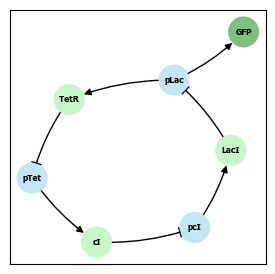

In [42]:
rep = lc.GeneticNetwork(vector=vector.id[0])

tetr_reg = lc.Regulator(name='TetR', degradation_rate=1, sbol_comp=geneproducts[3])
laci_reg = lc.Regulator(name='LacI', degradation_rate=1, init_concentration=5, sbol_comp=geneproducts[4])
ci_reg = lc.Regulator(name='cI', degradation_rate=1, sbol_comp=geneproducts[5])
rep.add_regulator([tetr_reg, laci_reg, ci_reg])

gfp_rep = lc.Reporter(name='GFP', degradation_rate=1, signal_id=gfps.id[0], sbol_comp=geneproducts[0], color='green')
rep.add_reporter(gfp_rep)

laci_not_tetr_gfp = lc.Hill1(name='pLac', input=laci_reg, output=[tetr_reg, gfp_rep], alpha=[1000,0.1], K=10, n=2, sbol_comp=op_plac, )
ci_not_laci = lc.Hill1(name='pcI', input=ci_reg, output=laci_reg, alpha=[1000,0.1], K=10, n=2, sbol_comp=op_plam)
tetr_not_ci = lc.Hill1(name='pTet', input=tetr_reg, output=ci_reg, alpha=[1000,0.1], K=10, n=2, sbol_comp=op_ptet)
rep.add_operator([laci_not_tetr_gfp, ci_not_laci,tetr_not_ci])

plt.figure(figsize=(3.3,3.3), dpi=100)
rep.draw()

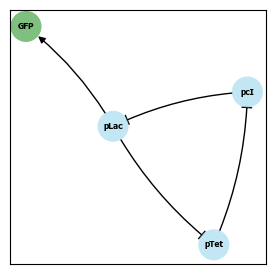

In [28]:
plt.figure(figsize=(3.3,3.3), dpi=100)
rep.draw(contracted=True)

In [29]:
repressilator_doc = rep.to_sbol(sbol_doc=doc)
for obj in repressilator_doc.objects:
    print(obj.identity)
report_sbol3 = repressilator_doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ
https://github.com/Gonza10V/L3S2P21_UPA20_pTetR_RiboJ_seq
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10
https://github.com/Gonza10V/L3S2P11_UPA20_pLac_RiboJ10_seq
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51
https://github.com/Gonza10V/L3S1P13_UPA20_plambda_RiboJ51_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS2
https://github.com/Gonza10V/RBS3
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/RBS2_seq
https://github.com/Gonza10V/RBS3_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/operator_plac
https://github.com/Gonza10V/operator_plam
https://github.com/Gonza10V/GFP
https://github.com/Gonza10V/GFP_seq
https://github.com/Gonza10V/TetR
https://github.com/Gonza10V/TetR_seq
https://github.com/Gonza10V/LacI
https://github.com/Gonza10V/LacI_seq
https://github.com/Gonza10V/LamR
https://github.com/Gonza10V/LamR_seq
https://github.com/Gonza10V/M0050
https:

In [30]:
doc.write('rep_loica_model.xml', sbol3.RDF_XML)

In [43]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA repressilator',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

100%|██████████| 100.0/100 [00:00<00:00, 172.94it/s]


In [44]:
assay.measurements

Time  Signal_id   Signal  Measurement  Sample
0     0.00       20.0      GFP     0.000000     0.0
1     0.00        4.0  Biomass     0.010347     0.0
2     0.25       20.0      GFP     0.326154     0.0
3     0.25        4.0  Biomass     0.010692     0.0
4     0.50       20.0      GFP     0.419095     0.0
..     ...        ...      ...          ...     ...
195  24.25        4.0  Biomass     0.999986     0.0
196  24.50       20.0      GFP    53.498924     0.0
197  24.50        4.0  Biomass     0.999988     0.0
198  24.75       20.0      GFP    52.306127     0.0
199  24.75        4.0  Biomass     0.999990     0.0

[200 rows x 5 columns]

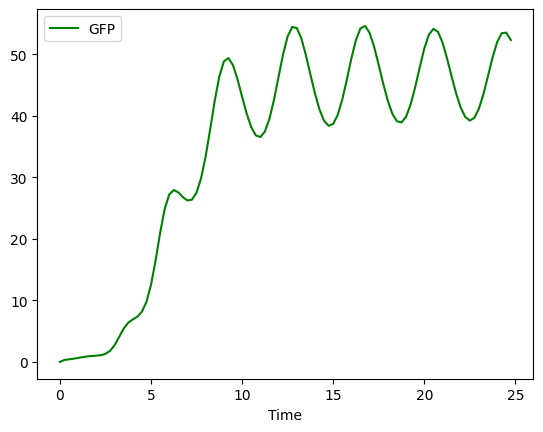

In [45]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

In [116]:
assay.upload(fj, study.id[0])

100%|██████████| 100.0/100 [00:02<00:00, 42.89it/s]


In [117]:
# Query and plot data using Python package
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

plt.figure(figsize=(1,1), dpi=300)
fig

100%|██████████| 100/100 [00:00<00:00, 170.35it/s]


<Figure size 300x300 with 0 Axes>

In [91]:
# Modify width and size
fig = fj.layout_print(fig, width=2, height=1, font_size=6)
fig

AttributeError: 'Flapjack' object has no attribute 'layout_print'

In [46]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA repressilator with noise',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(nsr=1e-3)

100%|██████████| 100.0/100 [00:00<00:00, 171.28it/s]


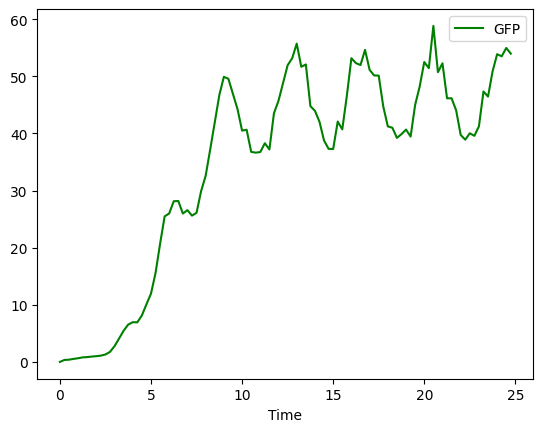

In [47]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

In [120]:
study = fj.create('study', name='Simple_repressilator_noise', description='Test for demonstration')

assay.upload(fj, study.id[0])


100%|██████████| 100.0/100 [00:02<00:00, 45.17it/s]


In [121]:
# Query and plot data using Python package
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

plt.figure(figsize=(1,2), dpi=300)
fig

100%|██████████| 100/100 [00:00<00:00, 1981.89it/s]


<Figure size 300x300 with 0 Axes>

In [52]:
def growth_rate(t):
    return 0

def biomass(t):
    return 1

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=1000, 
              interval=1e-2,
              name='LOICA repressilator stochastic',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(stochastic=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|█████████▉| 99.9999999999986/100 [00:04<00:00, 20.81it/s]  


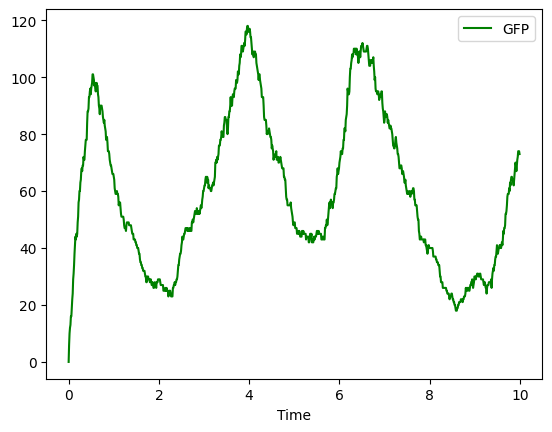

In [53]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

In [54]:
study = fj.create('study', name='Simple_repressilator_stochastic', description='Test for demonstration')

assay.upload(fj, study.id[0])

100%|██████████| 100.0/100 [00:09<00:00, 10.72it/s]


In [55]:
# Query and plot data using Python package
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

plt.figure(figsize=(1,1), dpi=300)
fig

100%|██████████| 100/100 [00:00<00:00, 213.57it/s]


<Figure size 300x300 with 0 Axes>

# Inverter characterization

In [3]:
study = fj.get('study', name='Voigt inverters')

yfp = fj.get('signal', name='YFP')

vector = fj.get('vector', name='pAN1818_cyan')

media = fj.get('media', name='M9 Glicerol')

strain = fj.get('strain', name='Top10')

biomass_signal = fj.get('signal', name='OD')

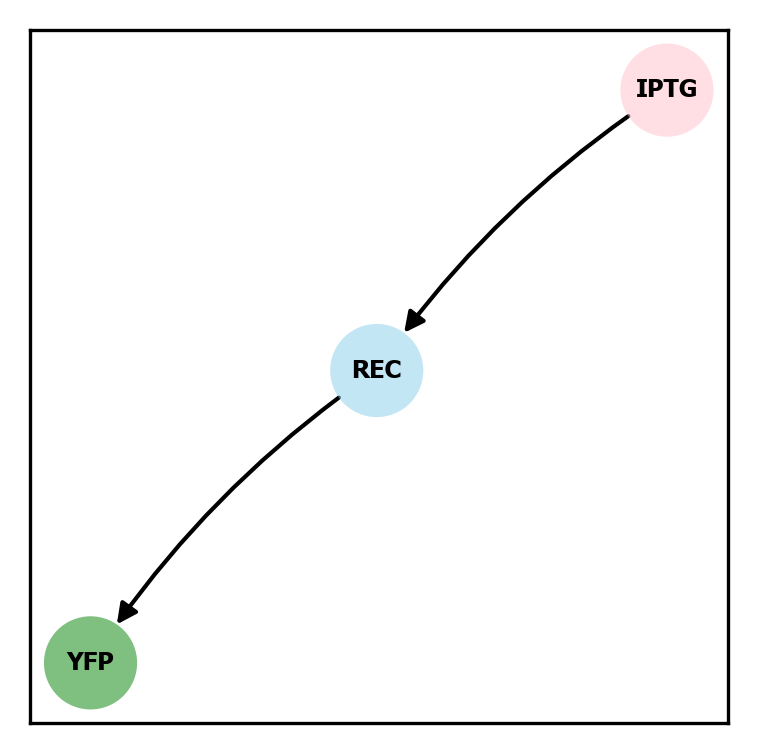

In [4]:
receiver = lc.GeneticNetwork(vector=vector.id[0])

iptg = lc.Supplement(name='IPTG')

yfp_rep = lc.Reporter(name='YFP', degradation_rate=0, signal_id=yfp.id[0], color='green')
receiver.add_reporter(yfp_rep)

iptg_rec_yfp = lc.Receiver(input=iptg, output=yfp_rep, alpha=[1e-3,1e4], K=1e-5, n=2)
receiver.add_operator(iptg_rec_yfp)

plt.figure(figsize=(3,3), dpi=300)
receiver.draw()

In [5]:
iptg_rec_yfp.characterize( fj,
    vector=vector.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id
)

100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


Returning dataframe


100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


Returning dataframe
0.0010000000000000005 10000.00000000001 9.999999999999997e-06 2.0
0.0009999997598216879 10000.00000000001 9.999999999999997e-06 2.0
0.0010000001372447765 10000.00137244777 9.999999999999997e-06 2.0
0.0010000000000000005 10000.00000000001 9.999998284440557e-06 2.0
0.0010000000000000005 10000.00000000001 9.999999999999997e-06 2.0000000298023224
6.022232190619277e-12 80646.5219057312 0.00033210324421307727 0.024496547848153142
0.00745084992549499 74508.51807163906 0.00027713544474896576 0.042769263064331375
0.003182272503687697 31822.72653187344 1.9790596400488127e-05 1.5660480523640117
0.003182271739374857 31822.72653187344 1.9790596400488127e-05 1.5660480523640117
0.003182272995330653 31822.731448303228 1.9790596400488127e-05 1.5660480523640117
0.003182272503687697 31822.72653187344 1.9790593206600783e-05 1.5660480523640117
0.003182272503687697 31822.72653187344 1.9790596400488127e-05 1.5660480756999462
0.04454321148333015 35012.78165146547 5.2315470606540895e-05 1.2

In [6]:
iptg_rec_yfp.alpha, iptg_rec_yfp.K, iptg_rec_yfp.n

([672.1838896759962, 32342.28884509808],
 4.1806631621717195e-05,
 2.484084892568149)

In [7]:
iptg_rec_yfp.alpha[1]/iptg_rec_yfp.alpha[0]

48.11523950787872

# NOT characterization

## SrpR

In [8]:
vector2 = fj.get('vector', name='pSrpR-S3_cyan')

In [9]:
inverter = lc.GeneticNetwork(vector=vector2.id[0])

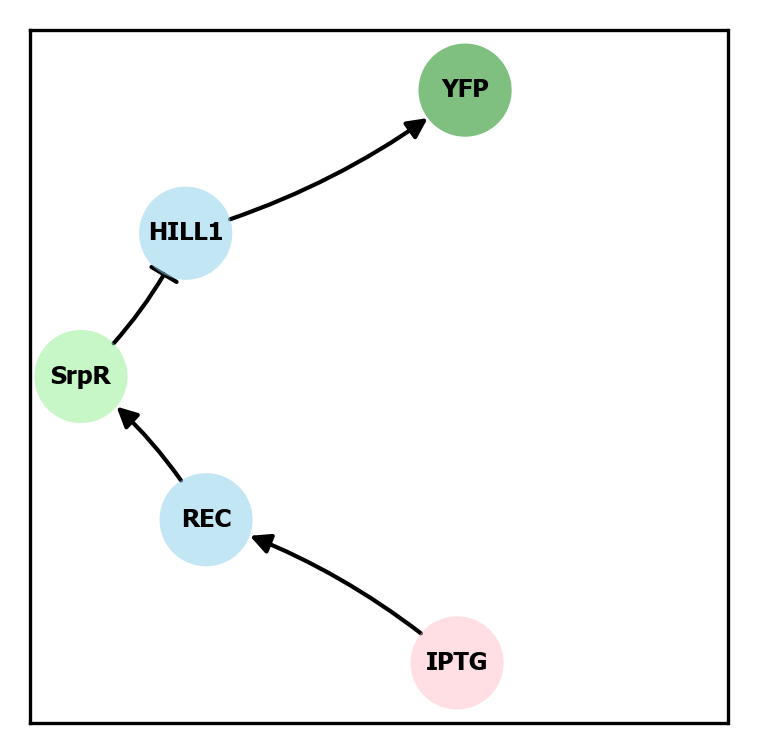

In [10]:
inverter.add_reporter(yfp_rep)

srpr_reg = lc.Regulator('SrpR')
inverter.add_regulator(srpr_reg)

iptg_rec_srpr = iptg_rec_yfp
iptg_rec_srpr.output = srpr_reg
srpr_not_yfp = lc.Hill1(input=srpr_reg, output=yfp_rep, alpha=[10,1e-3], K=1e3, n=2)
inverter.add_operator([srpr_not_yfp, iptg_rec_srpr])

plt.figure(figsize=(3,3), dpi=300)
inverter.draw()

In [11]:
srpr_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector2.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

100%|██████████| 100/100 [00:10<00:00,  9.12it/s]


Returning dataframe


100%|██████████| 100/100 [00:08<00:00, 12.37it/s]


Returning dataframe
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0000000298023224
9.999999999999993 0.0010000000000000002 1000.0001029335796 2.0
10.000001372447755 0.0010000000000000002 999.9999999999998 2.0
9.999998970664302 0.000999999897066431 999.9999999999998 2.0
223276.4078188926 0.15003294158911992 1876836.4657246207 0.00037170834541854517
122.24281479790484 0.003499878154495043 6582.055713707882 0.2335257506433426
122.24281479790484 0.003499878154495043 6582.055713707882 0.23352574558209552
122.24281479790484 0.003499878154495043 6582.0565760397385 0.2335257506433426
122.2428338533107 0.003499878154495043 6582.055713707882 0.2335257506433426
122.24280449693465 0.003499877859572674 6582.055713707882 0.2335257506433426
1593028.2705272706 0.3995602001045858 11352.366674450186 0.2344625508896744
1305.9080487854178 0.011439446140783245 7549.790882532741 0.23137529510367924
1305.9080487854178 0.0114394461407

In [12]:
srpr_not_yfp.alpha, srpr_not_yfp.K, srpr_not_yfp.n

([53940.90880307989, 829.7377838179816], 4562.435279376597, 1.8932009742260376)

In [13]:
srpr_not_yfp.alpha[1]/srpr_not_yfp.alpha[0]

0.01538234713187861

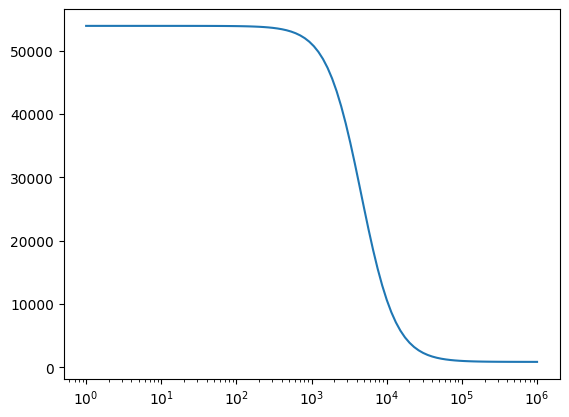

In [14]:
a = srpr_not_yfp.alpha[0]
b = srpr_not_yfp.alpha[1]
K = srpr_not_yfp.K
n = srpr_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## BetI

In [15]:
vector3 = fj.get('vector', name='pBetI-E1_cyan')

In [16]:
inverter_pbeti = lc.GeneticNetwork(vector=vector3.id[0])

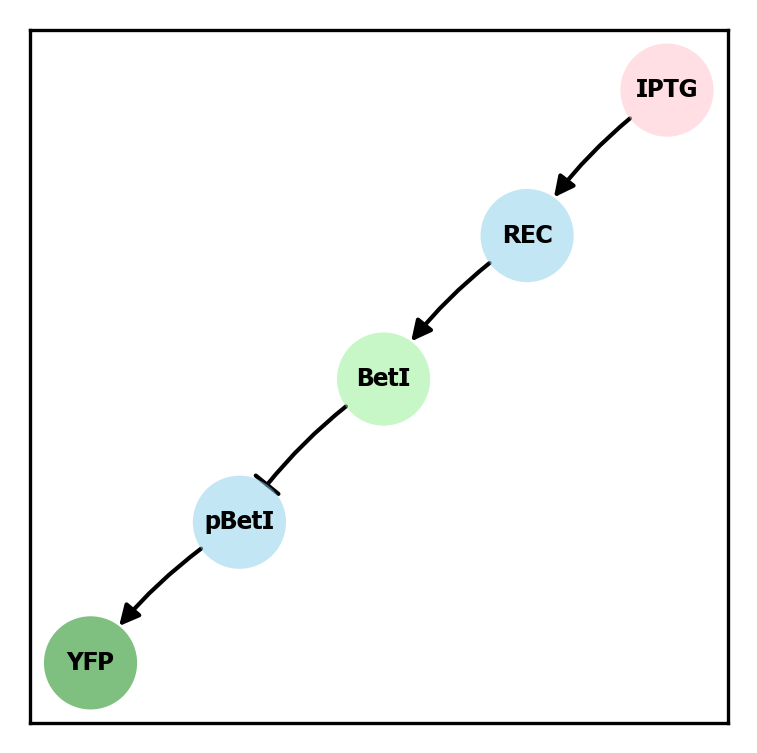

In [17]:
inverter_pbeti.add_reporter(yfp_rep)

beti_reg = lc.Regulator('BetI')
inverter_pbeti.add_regulator(beti_reg)

iptg_rec_beti = iptg_rec_yfp
iptg_rec_beti.output = beti_reg
beti_not_yfp = lc.Hill1(name='pBetI',input=beti_reg, output=yfp_rep, alpha=[10,1e-3], K=1e3, n=2)
inverter_pbeti.add_operator([iptg_rec_beti, beti_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_pbeti.draw()

In [18]:
beti_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector3.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


Returning dataframe


100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


Returning dataframe
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0000000298023224
9.999999999999993 0.0010000000000000002 1000.0001029335796 2.0
10.000001372447755 0.0010000000000000002 999.9999999999998 2.0
9.999998970664302 0.000999999897066431 999.9999999999998 2.0
213968.37785510448 0.14696930070630657 1927549.1345342337 0.0003712142446652957
120.94932129100832 0.0034818864398872933 6626.139778439987 0.23345118650809585
120.94932129100832 0.0034818864398872933 6626.139778439987 0.23345118144735388
120.94932129100832 0.0034818864398872933 6626.140647206514 0.23345118650809585
120.94934013489907 0.0034818864398872933 6626.139778439987 0.23345118650809585
120.94931108974748 0.003481886146213617 6626.139778439987 0.23345118650809585
1571885.4097027015 0.396966913049872 11568.266405183822 0.20884402385435624
1291.1993046803443 0.011376726825935303 7619.330355618089 0.22608462567185228
1291.1993046803443 0.01137

In [19]:
beti_not_yfp.alpha, beti_not_yfp.K, beti_not_yfp.n

([45235.573166402595, 6.967191264301526e-06],
 19742.434805720946,
 1.687718004447078)

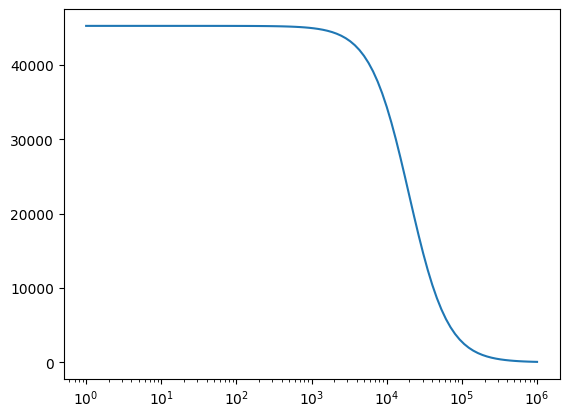

In [20]:
a = beti_not_yfp.alpha[0]
b = beti_not_yfp.alpha[1]
K = beti_not_yfp.K
n = beti_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## QacR

In [21]:
vector4 = fj.get('vector', name='pQacR_Q1_cyan')

In [22]:
inverter_pqacr = lc.GeneticNetwork(vector=vector4.id[0])

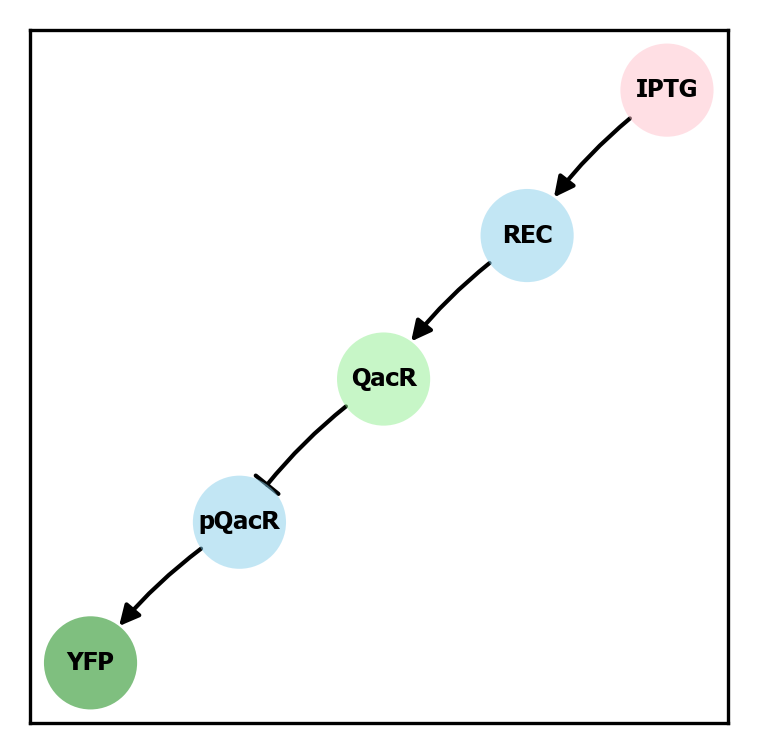

In [23]:
inverter_pqacr.add_reporter(yfp_rep)

qacr_reg = lc.Regulator('QacR')
inverter_pqacr.add_regulator(beti_reg)

iptg_rec_qacr = iptg_rec_yfp
iptg_rec_qacr.output = qacr_reg
qacr_not_yfp = lc.Hill1(name='pQacR',input=qacr_reg, output=yfp_rep, alpha=[10,1e-3], K=1e3, n=2)
inverter_pqacr.add_operator([iptg_rec_qacr, qacr_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_pqacr.draw()

In [24]:
qacr_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector4.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

100%|██████████| 100/100 [00:02<00:00, 49.58it/s]


Returning dataframe


100%|██████████| 100/100 [00:03<00:00, 26.51it/s]


Returning dataframe
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0000000298023224
9.999999999999993 0.0010000000000000002 1000.0001029335796 2.0
10.000001372447755 0.0010000000000000002 999.9999999999998 2.0
9.999998970664302 0.000999999897066431 999.9999999999998 2.0
253390.87179645753 0.15973575855309194 2144846.0373821757 0.00045154327689600926
126.1683345720891 0.003555100136347862 6805.319246672455 0.24515934229066688
126.1683345720891 0.003555100136347862 6805.319246672455 0.2451593371548848
126.1683345720891 0.003555100136347862 6805.320141637323 0.24515934229066688
126.16835426940301 0.003555100136347862 6805.319246672455 0.24515934229066688
126.16832396976166 0.003555099837601462 6805.319246672455 0.24515934229066688
1639136.6361575446 0.40523929554401317 11892.984610095778 0.2766687768482687
1347.1199608961715 0.011616805950980096 7831.029753618485 0.25050524612086633
1347.1199608961715 0.01161680595

In [25]:
qacr_not_yfp.alpha, qacr_not_yfp.K, qacr_not_yfp.n

([88243.0067513327, 810.7908883031687], 2949.3364670536894, 2.280366888762804)

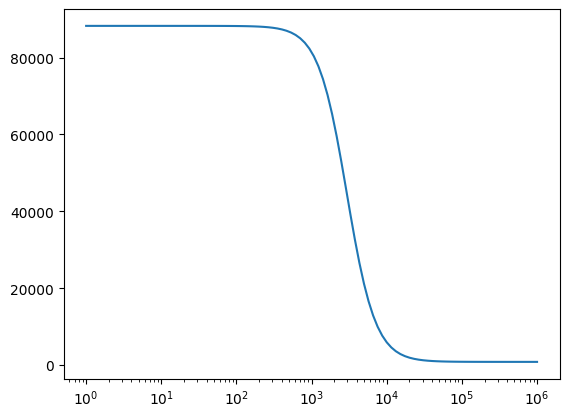

In [27]:
a = qacr_not_yfp.alpha[0]
b = qacr_not_yfp.alpha[1]
K = qacr_not_yfp.K
n = qacr_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## pBM3R1-B2_cyan

In [28]:
vector5 = fj.get('vector', name='pBM3R1-B2_cyan')

In [29]:
inverter_pbm3r1 = lc.GeneticNetwork(vector=vector5.id[0])

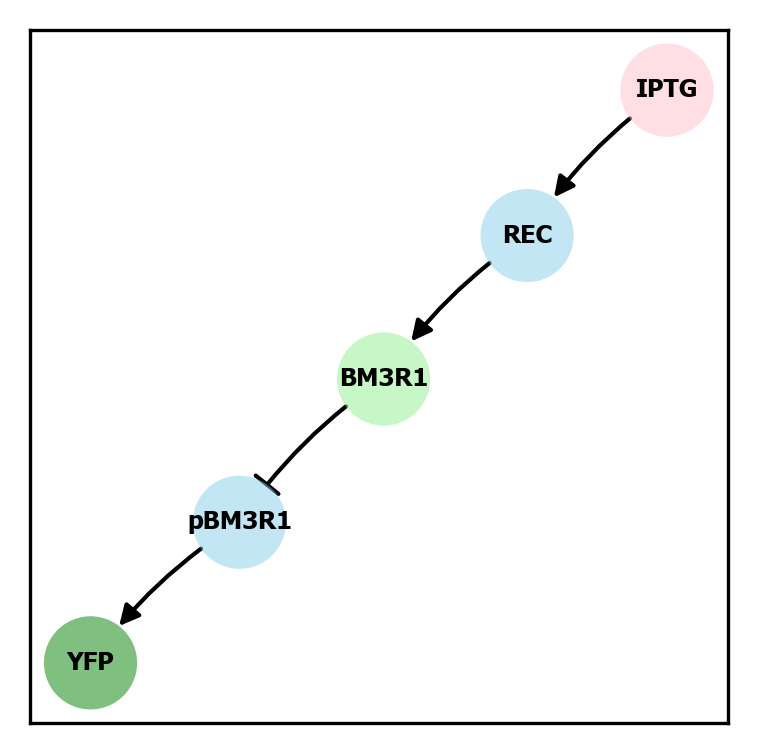

In [30]:
inverter_pbm3r1.add_reporter(yfp_rep)

bm3r1_reg = lc.Regulator('BM3R1')
inverter_pbm3r1.add_regulator(bm3r1_reg)

iptg_rec_bm3r1 = iptg_rec_yfp
iptg_rec_bm3r1.output = bm3r1_reg
bm3r1_not_yfp = lc.Hill1(name='pBM3R1',input=bm3r1_reg, output=yfp_rep, alpha=[10,1e-3], K=1e3, n=2)
inverter_pbm3r1.add_operator([iptg_rec_bm3r1, bm3r1_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_pbm3r1.draw()

In [31]:
bm3r1_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector5.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

100%|██████████| 100/100 [00:03<00:00, 31.17it/s]


Returning dataframe


100%|██████████| 100/100 [00:03<00:00, 30.29it/s]


Returning dataframe
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0000000298023224
9.999999999999993 0.0010000000000000002 1000.0001029335796 2.0
10.000001372447755 0.0010000000000000002 999.9999999999998 2.0
9.999998970664302 0.000999999897066431 999.9999999999998 2.0
226079.33197620555 0.1512155576546976 1732392.625157875 0.0003492265810619368
122.6513862826357 0.003507128352622884 6452.700652432537 0.22997485681294355
122.6513862826357 0.003507128352622884 6452.700652432537 0.22997485177614757
122.6513862826357 0.003507128352622884 6452.701495908785 0.22997485681294355
122.65140540404654 0.003507128352622884 6452.700652432537 0.22997485681294355
122.65137595101879 0.0035071280571977144 6452.700652432537 0.22997485681294355
1590511.212470246 0.3994068432135207 11250.527559908374 0.19090349051844635
1305.8790403876546 0.011443933040389001 7436.0435513661805 0.21185673718539608
1305.8790403876546 0.011443933040

In [32]:
bm3r1_not_yfp.alpha, bm3r1_not_yfp.K, bm3r1_not_yfp.n

([5318.980602551893, 0.00016289710278840388],
 26918.52208906818,
 1.2878739676060178)

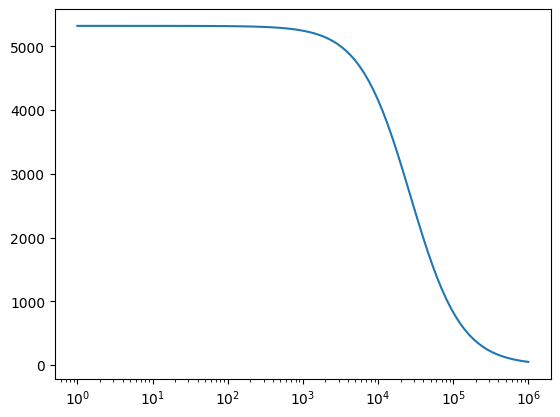

In [33]:
a = bm3r1_not_yfp.alpha[0]
b = bm3r1_not_yfp.alpha[1]
K = bm3r1_not_yfp.K
n = bm3r1_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## lcaRA

In [34]:
vector6 = fj.get('vector', name='plcaRA_I1_cyan')

In [35]:
inverter_plcara = lc.GeneticNetwork(vector=vector6.id[0])

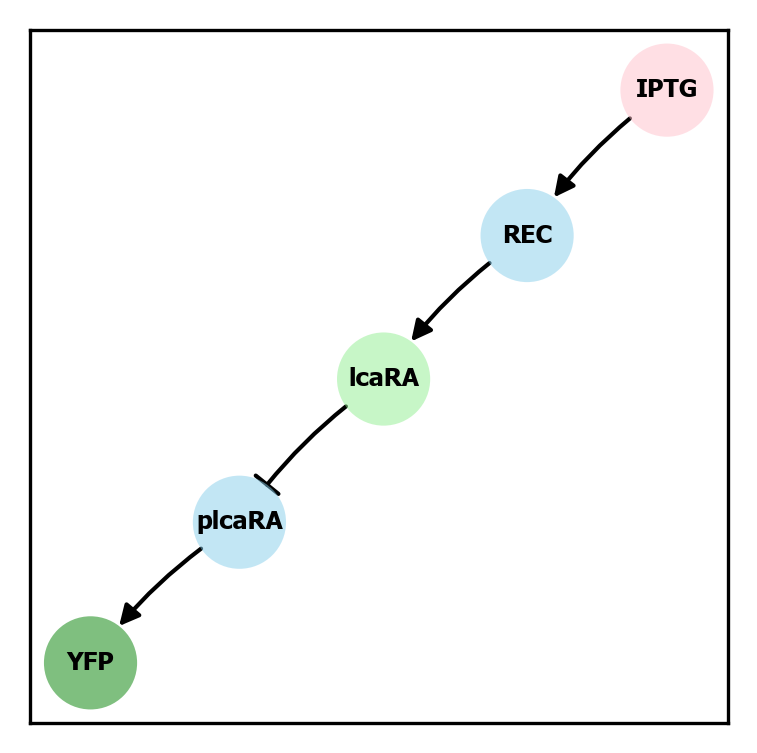

In [36]:
inverter_plcara.add_reporter(yfp_rep)

lcara_reg = lc.Regulator('lcaRA')
inverter_plcara.add_regulator(lcara_reg)

iptg_rec_lcara = iptg_rec_yfp
iptg_rec_lcara.output = lcara_reg
lcara_not_yfp = lc.Hill1(name='plcaRA',input=lcara_reg, output=yfp_rep, alpha=[10,1e-3], K=1e3, n=2)
inverter_plcara.add_operator([iptg_rec_lcara, lcara_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_plcara.draw()

In [37]:
lcara_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector6.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

100%|██████████| 100/100 [00:03<00:00, 29.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


Returning dataframe
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0
9.999999999999993 0.0010000000000000002 999.9999999999998 2.0000000298023224
9.999999999999993 0.0010000000000000002 1000.0001029335796 2.0
10.000001372447755 0.0010000000000000002 999.9999999999998 2.0
9.999998970664302 0.000999999897066431 999.9999999999998 2.0
230591.5767655221 0.1525032750515429 2035734.9923057267 0.00040711708215650835
123.23208433411766 0.0035141976529758446 6717.19018877022 0.2389002180991731
123.23208433411766 0.0035141976529758446 6717.19018877022 0.23890021300244457
123.23208433411766 0.0035141976529758446 6717.191070840588 0.2389002180991731
123.23210355103551 0.0035141976529758446 6717.19018877022 0.2389002180991731
123.23207395728302 0.003514197357060636 6717.19018877022 0.2389002180991731
1601025.4511689965 0.40058412817903083 11820.2173204925 0.2201768895884112
1315.4680489225095 0.01148185574118592 7739.850809648794 0.23295979465382913
1315.4680489225095 0.0114818557411859

In [38]:
lcara_not_yfp.alpha, lcara_not_yfp.K, lcara_not_yfp.n

([122386.32402802838, 217.38317520865547],
 1112.2113286644135,
 0.8595952270055293)

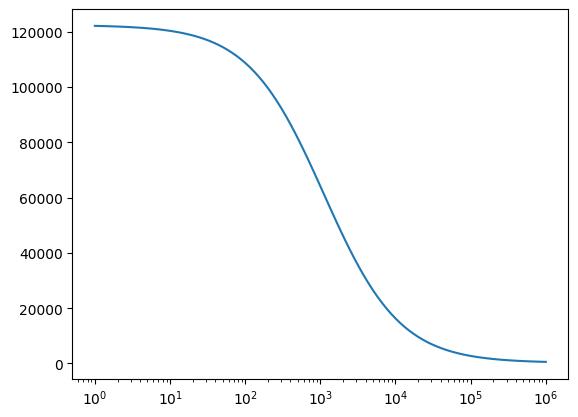

In [39]:
a = lcara_not_yfp.alpha[0]
b = lcara_not_yfp.alpha[1]
K = lcara_not_yfp.K
n = lcara_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## Oscillator

In [42]:
oscillator = lc.GeneticNetwork(vector=0)

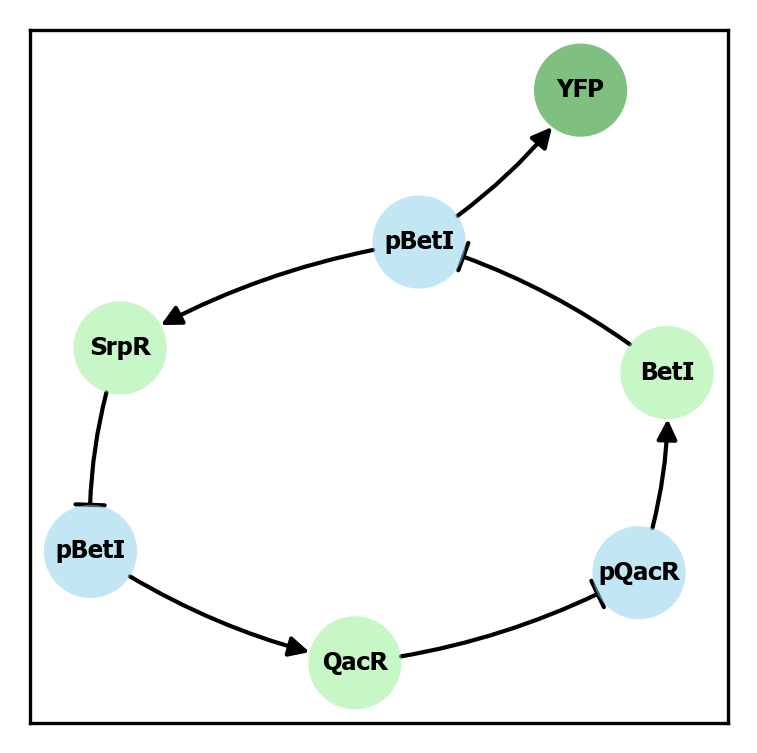

In [44]:
oscillator.add_reporter(yfp_rep)

oscillator.add_regulator([beti_reg, srpr_reg, qacr_reg])

beti_not_srpr = beti_not_yfp
beti_not_srpr.input = beti_reg
beti_not_srpr.output = [srpr_reg, yfp_rep]

srpr_not_qacr = srpr_not_yfp
srpr_not_qacr.input = srpr_reg
srpr_not_qacr.output = qacr_reg

qacr_not_beti = qacr_not_yfp
qacr_not_beti.input = qacr_reg
qacr_not_beti.output = beti_reg
oscillator.add_operator([beti_not_srpr, srpr_not_qacr, qacr_not_beti])

plt.figure(figsize=(3,3), dpi=300)
oscillator.draw()

In [45]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=oscillator, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA repressilator',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

100%|██████████| 100.0/100 [00:01<00:00, 93.64it/s]


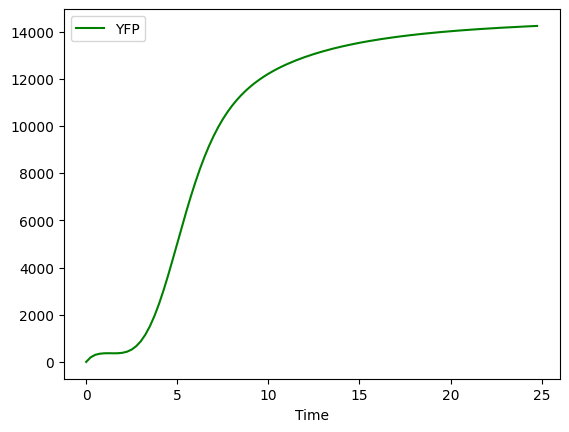

In [47]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='YFP'].plot(x='Time', y='Measurement', ax=ax, label='YFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

# Repressilator generator

In [41]:
from itertools import permutations 

In [42]:
srpr_reg = lc.Regulator('SrpR', degradation_rate=1)
beti_reg = lc.Regulator('BetI', degradation_rate=1)
qacr_reg = lc.Regulator('QacR', degradation_rate=1)
bm3r1_reg = lc.Regulator('BM3R1', degradation_rate=1)
lcara_reg = lc.Regulator('lcaRA', degradation_rate=1)

NOT_SrpR = [srpr_reg, srpr_not_yfp.alpha[0], srpr_not_yfp.alpha[1], srpr_not_yfp.K, srpr_not_yfp.n]
NOT_BetI = [beti_reg, beti_not_yfp.alpha[0], beti_not_yfp.alpha[1], beti_not_yfp.K, beti_not_yfp.n]
NOT_QacR = [qacr_reg, qacr_not_yfp.alpha[0], qacr_not_yfp.alpha[1], qacr_not_yfp.K, qacr_not_yfp.n]
NOT_BM3R1 = [bm3r1_reg, bm3r1_not_yfp.alpha[0], bm3r1_not_yfp.alpha[1], bm3r1_not_yfp.K, bm3r1_not_yfp.n]
NOT_lcaRA = [lcara_reg, lcara_not_yfp.alpha[0], lcara_not_yfp.alpha[1], lcara_not_yfp.K, lcara_not_yfp.n]

perms = []
perm = permutations([NOT_SrpR, 
                     NOT_BetI,
                     NOT_QacR,
                     NOT_BM3R1,
                     NOT_lcaRA,
                    ],3)  #with a larger list then we can do ([NOT_1, NOT_2, NOT_3],3)
for i in list(perm):  
    perms.append(i) 

print(perms)

[([<loica.geneproduct.Regulator object at 0x7fd39638f670>, 53940.90880307989, 829.7377838179816, 4562.435279376597, 1.8932009742260376], [<loica.geneproduct.Regulator object at 0x7fd39638f6a0>, 45235.573166402595, 6.967191264301526e-06, 19742.434805720946, 1.687718004447078], [<loica.geneproduct.Regulator object at 0x7fd39638f640>, 88243.0067513327, 810.7908883031687, 2949.3364670536894, 2.280366888762804]), ([<loica.geneproduct.Regulator object at 0x7fd39638f670>, 53940.90880307989, 829.7377838179816, 4562.435279376597, 1.8932009742260376], [<loica.geneproduct.Regulator object at 0x7fd39638f6a0>, 45235.573166402595, 6.967191264301526e-06, 19742.434805720946, 1.687718004447078], [<loica.geneproduct.Regulator object at 0x7fd39638f610>, 5318.980602551893, 0.00016289710278840388, 26918.52208906818, 1.2878739676060178]), ([<loica.geneproduct.Regulator object at 0x7fd39638f670>, 53940.90880307989, 829.7377838179816, 4562.435279376597, 1.8932009742260376], [<loica.geneproduct.Regulator objec

  0%|          | 0/100 [00:00<?, ?it/s]

100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 57.22it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 51.56it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 51.96it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 51.63it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 53.35it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 56.58it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 56.62it/s] 
100%|█████████▉| 99.99999999999966/100 [00:02<00:00, 35.03it/s] 
100%|█████████▉| 99.99999999999966/100 [00:02<00:00, 49.00it/s] 
100%|█████████▉| 99.99999999999966/100 [00:02<00:00, 46.45it/s] 
100%|█████████▉| 99.99999999999966/100 [00:02<00:00, 46.99it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 52.75it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 54.67it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 53.25it/s] 
100%|█████████▉| 99.99999999999966/100 [00:01<00:00, 50.77it/s] 
100%|█████████▉| 99.99999

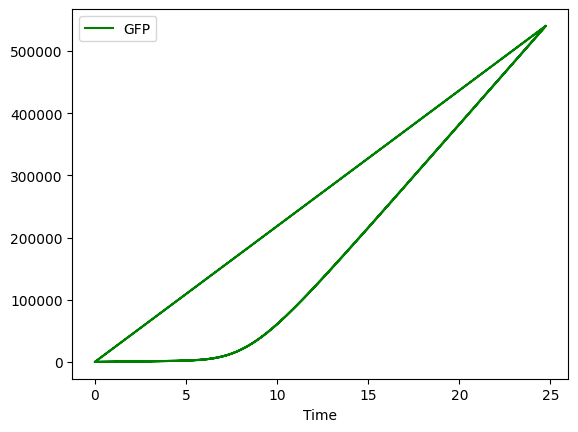

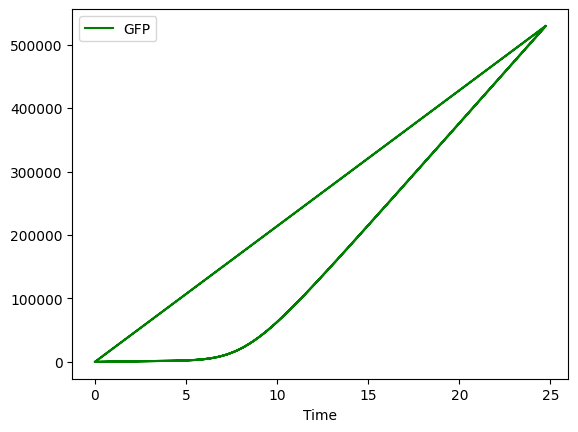

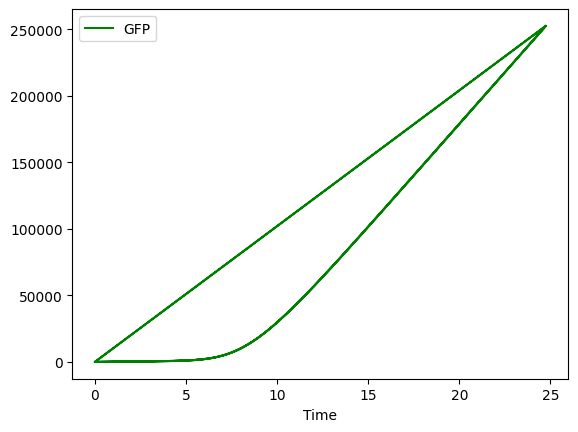

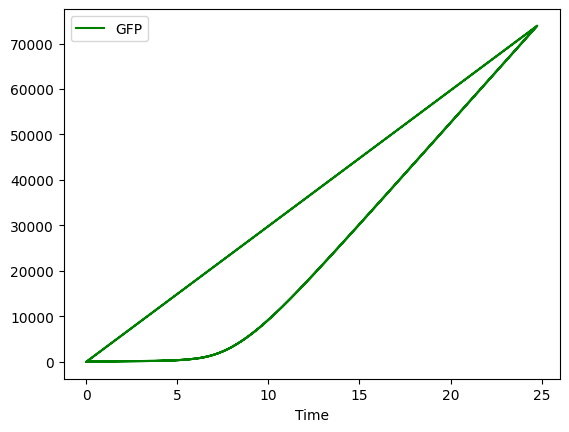

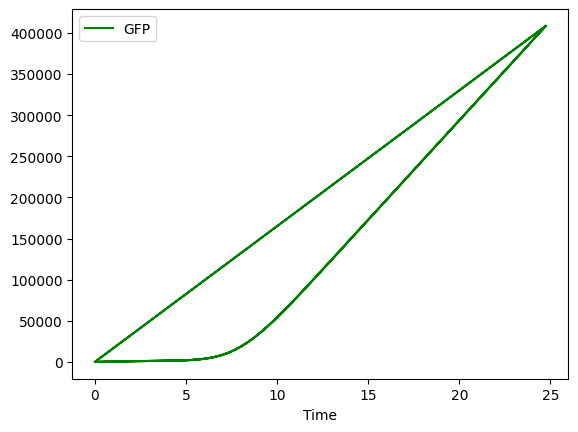

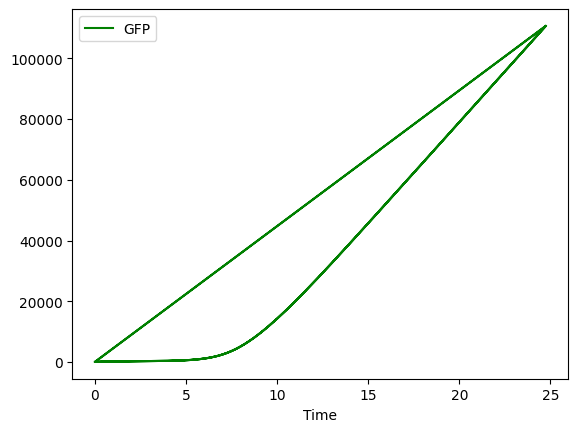

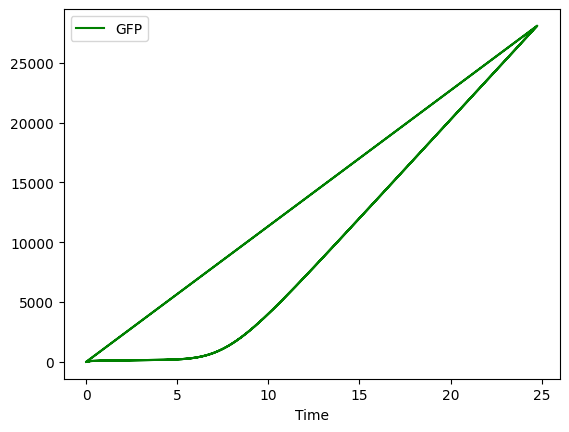

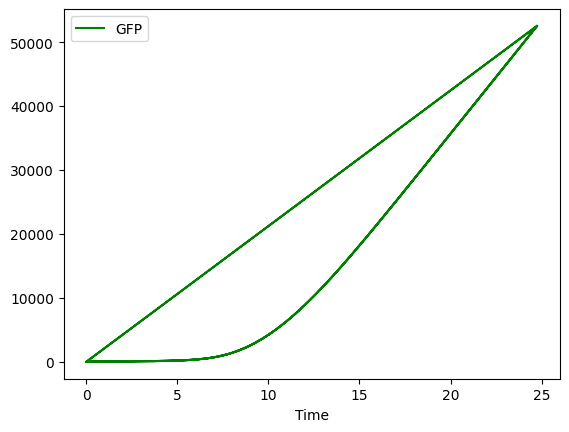

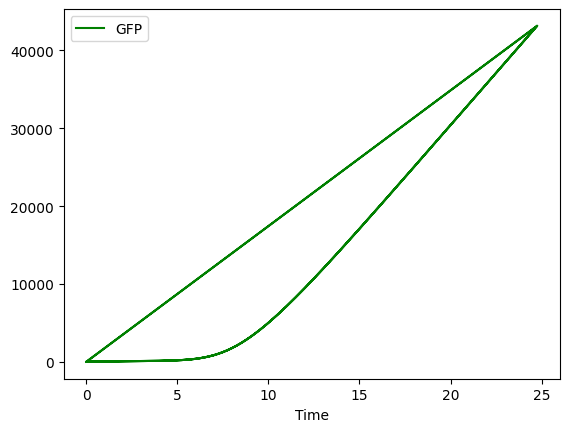

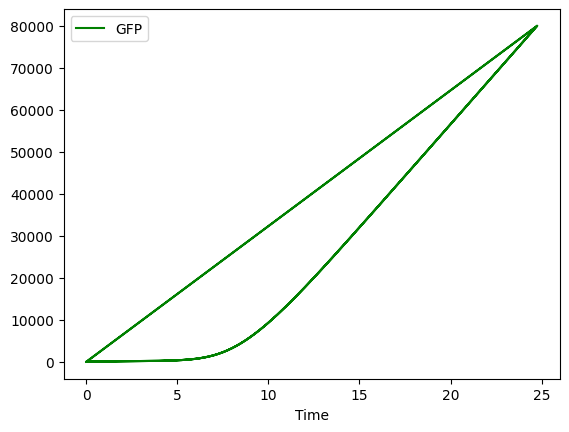

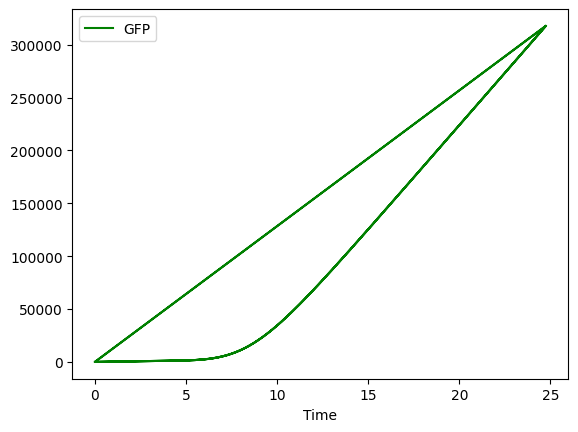

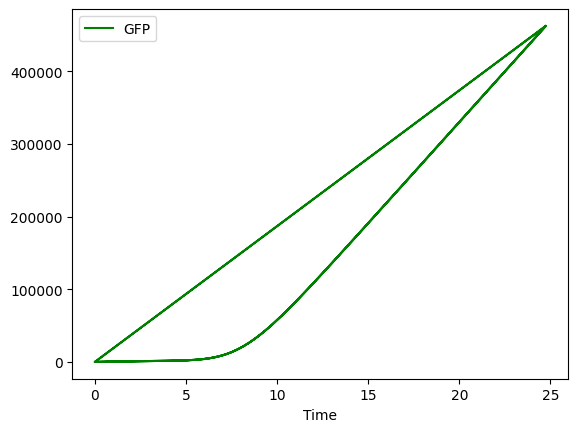

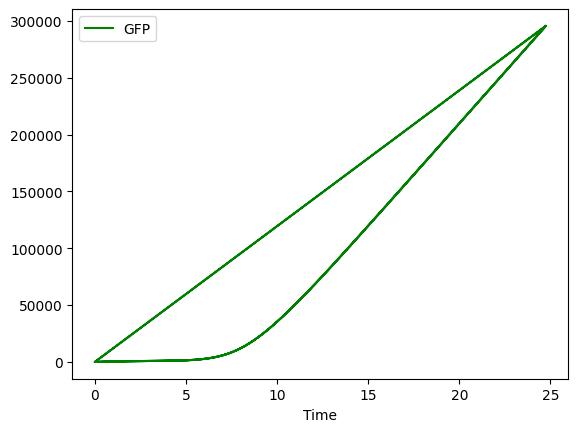

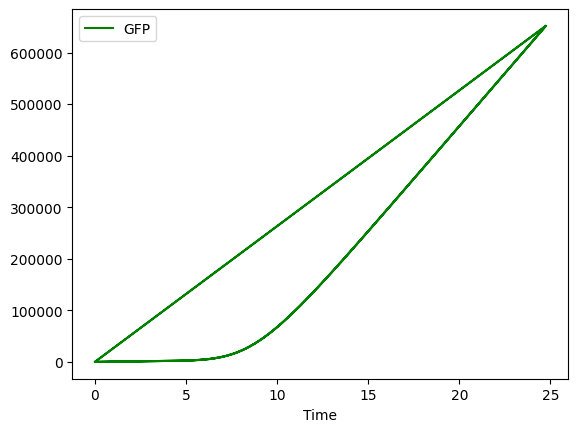

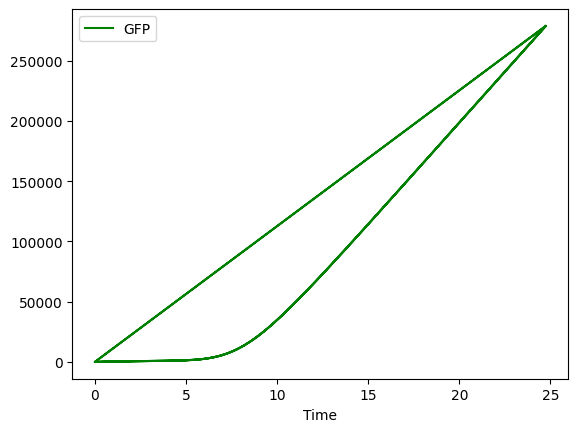

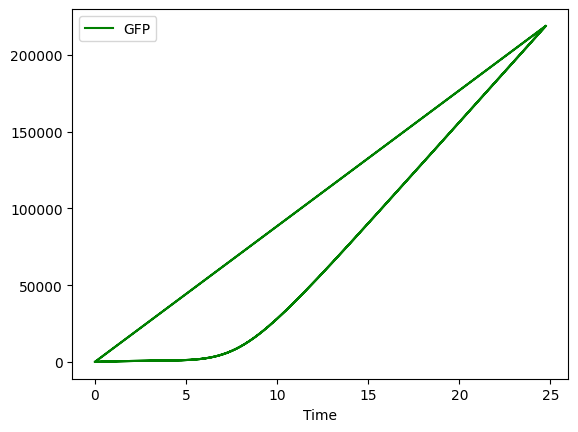

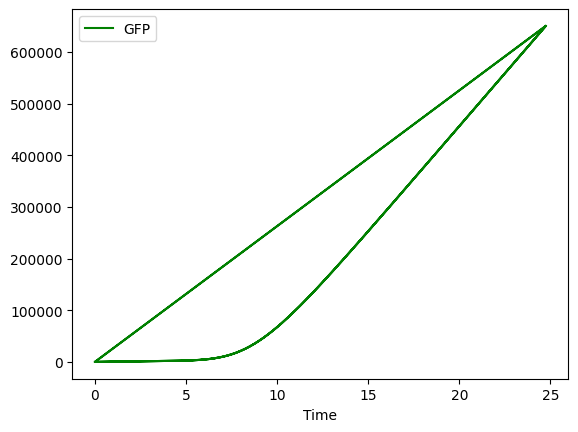

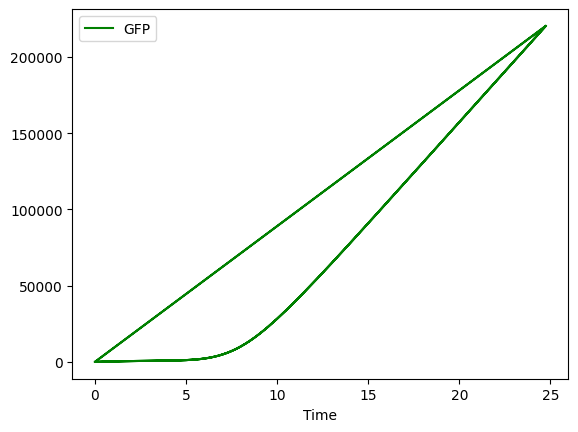

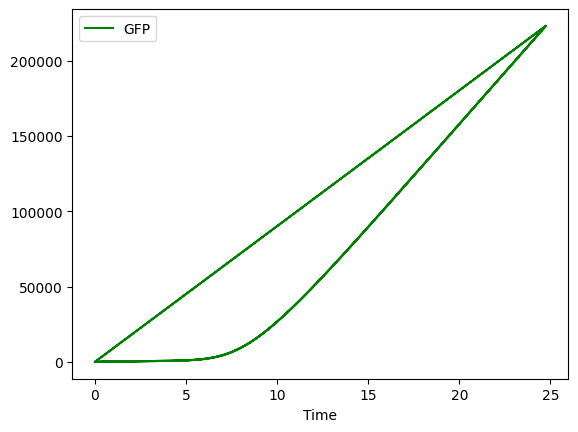

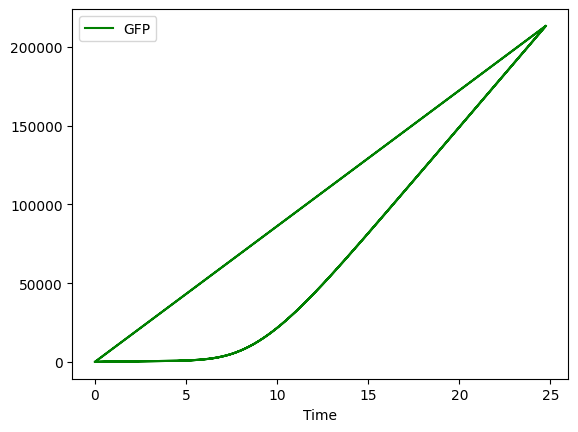

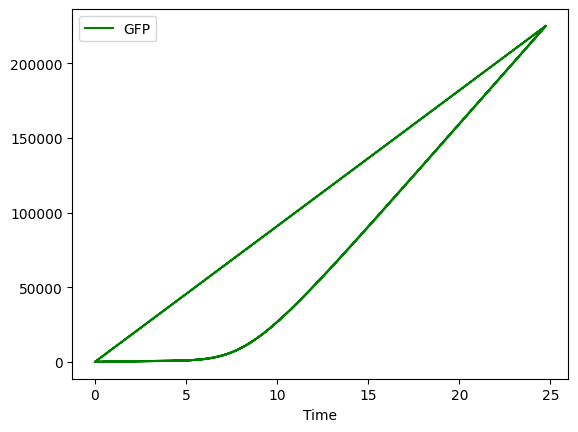

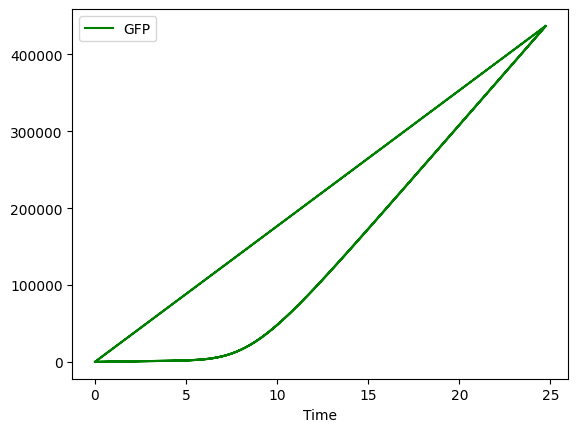

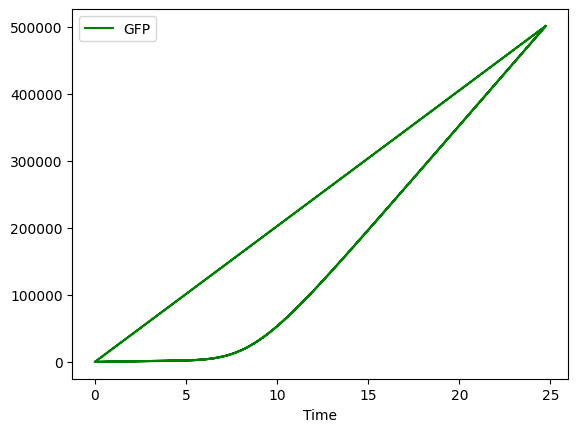

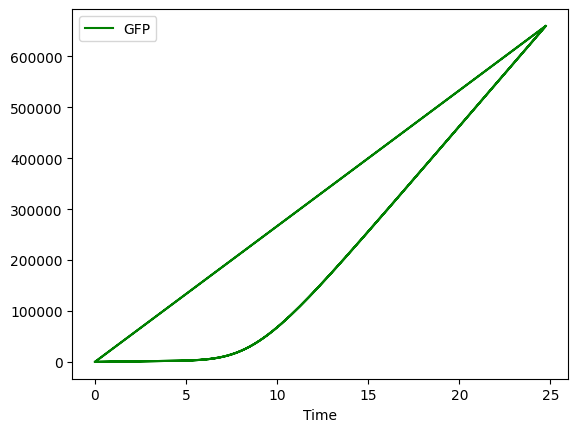

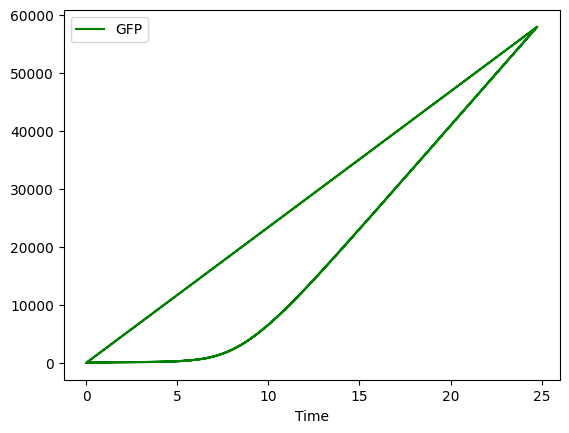

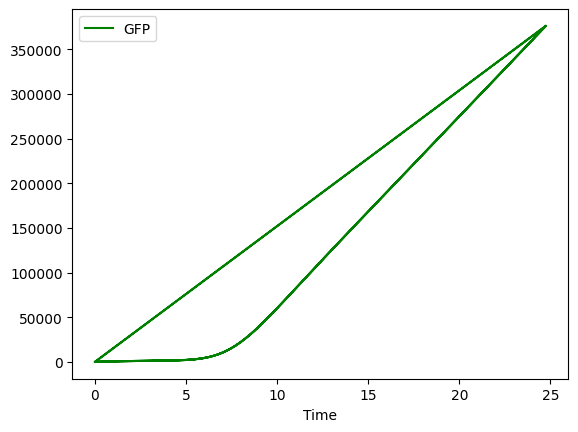

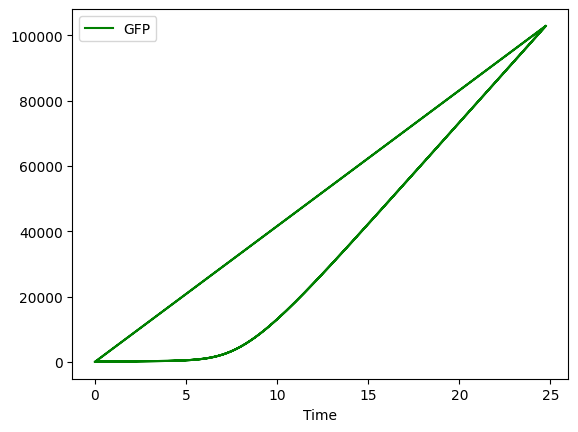

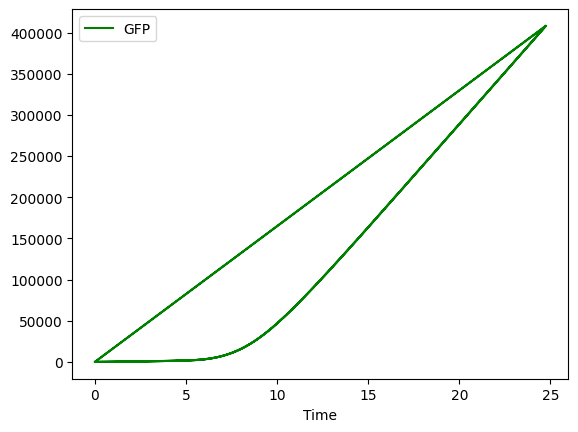

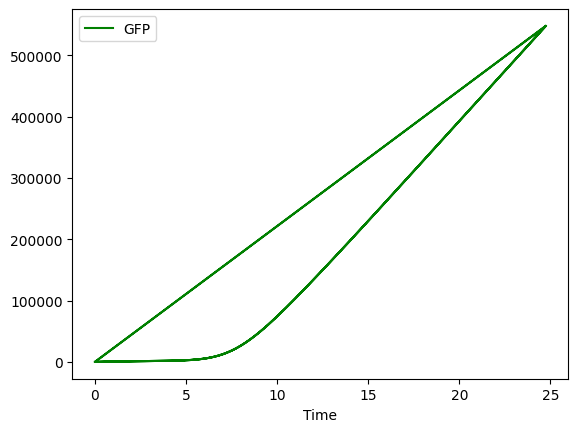

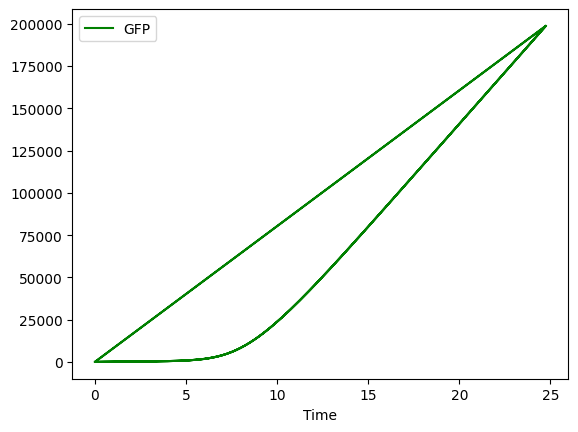

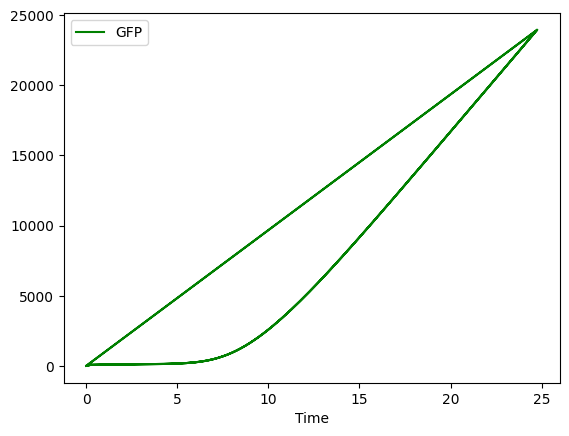

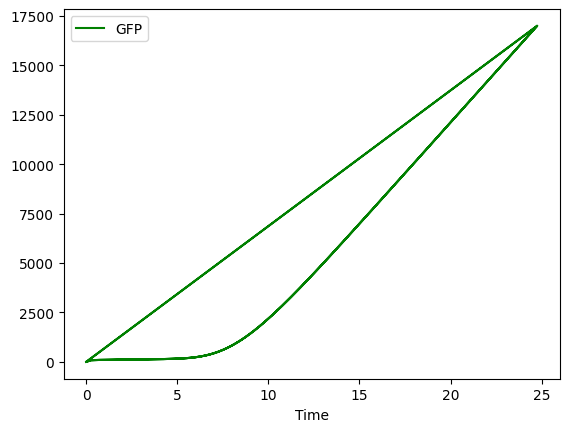

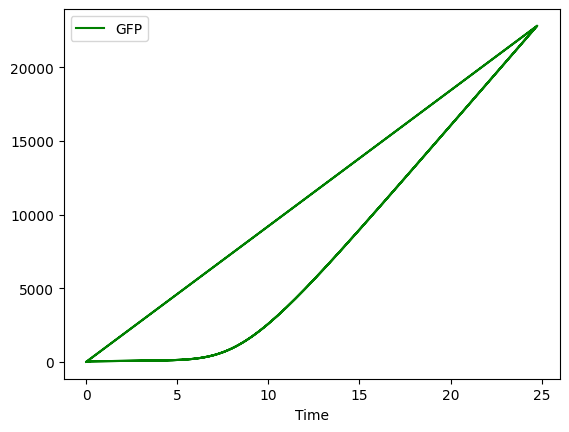

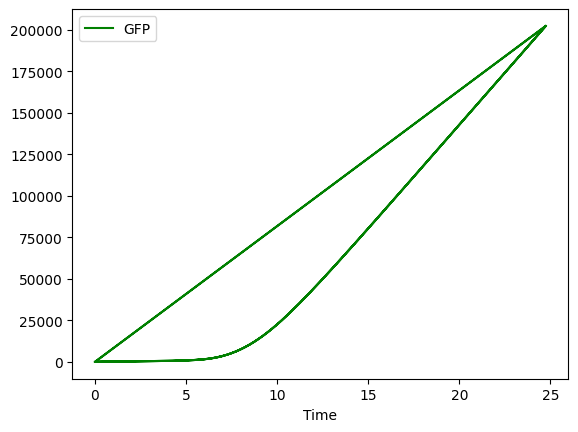

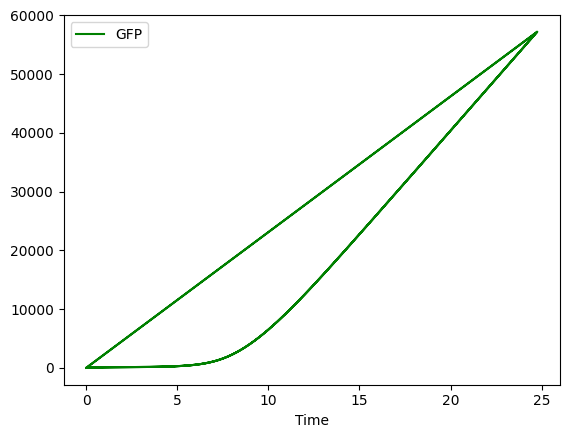

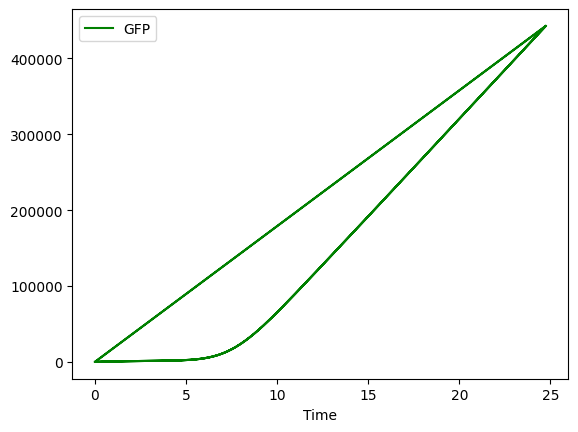

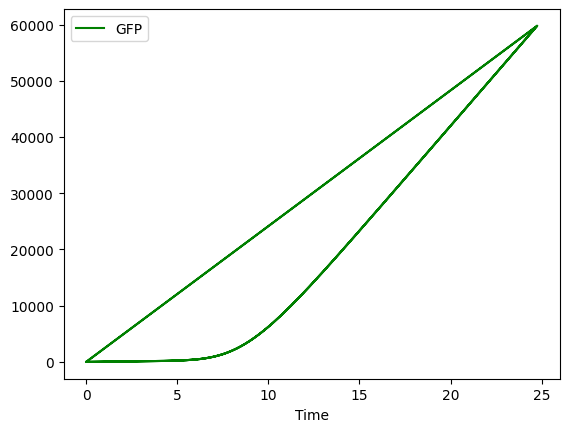

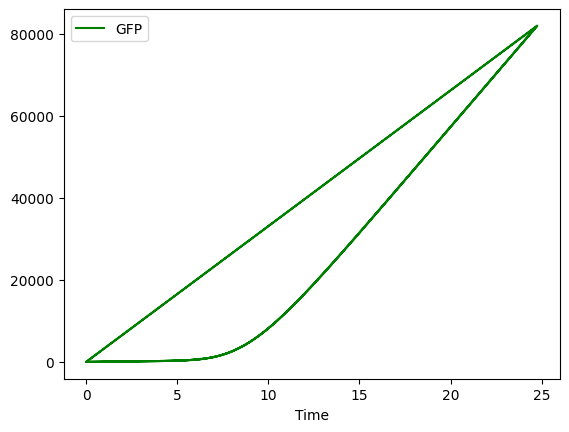

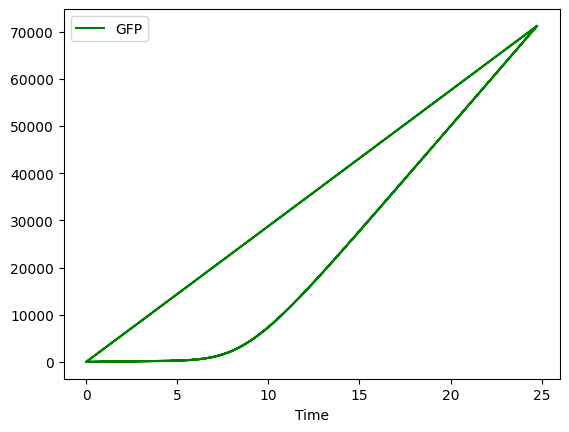

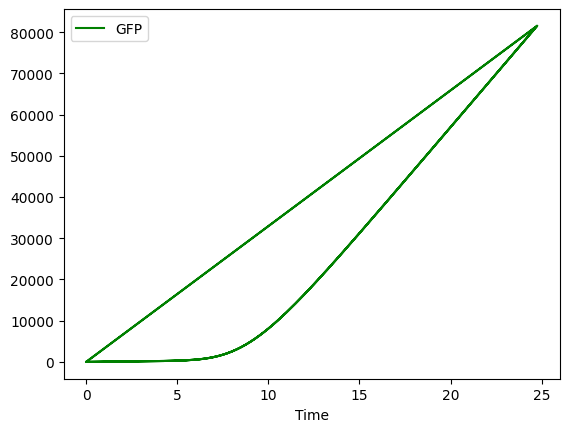

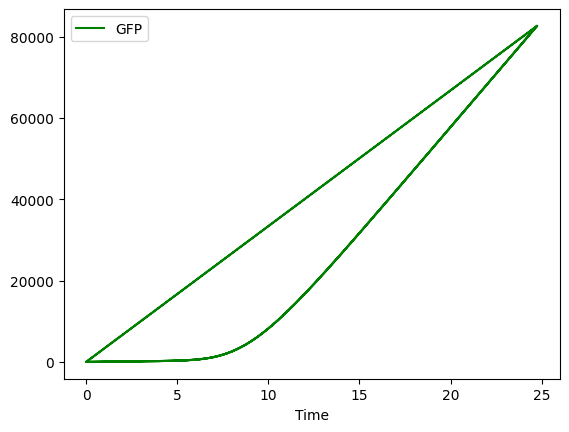

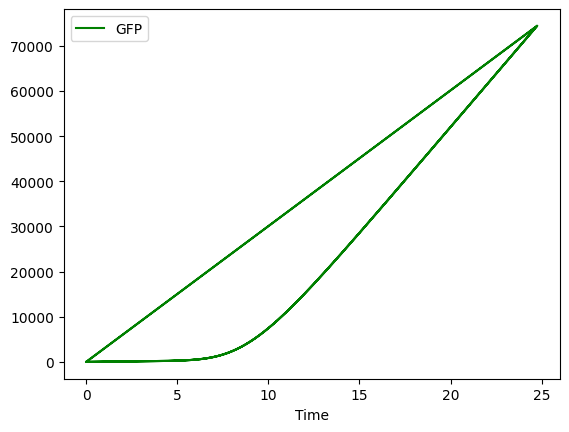

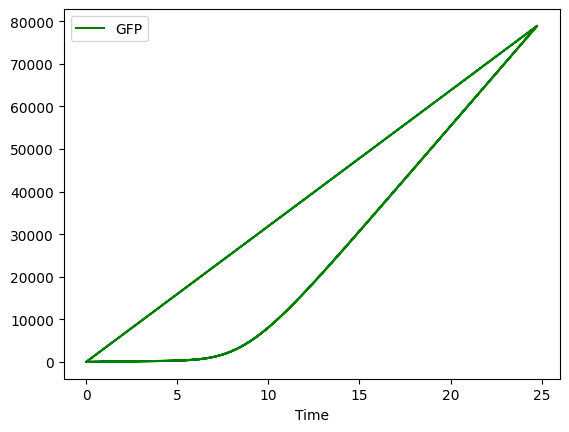

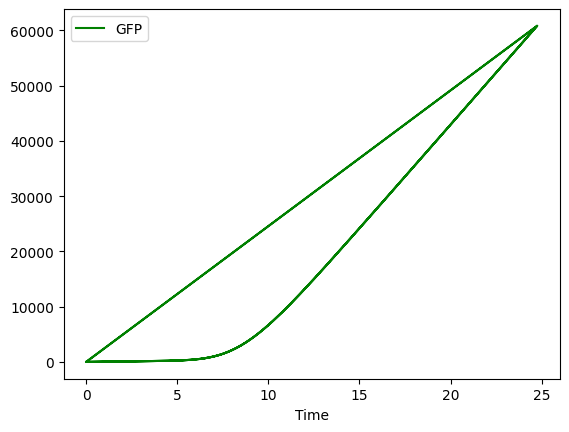

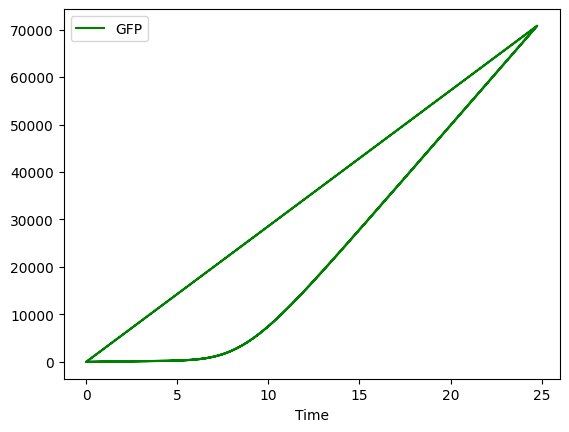

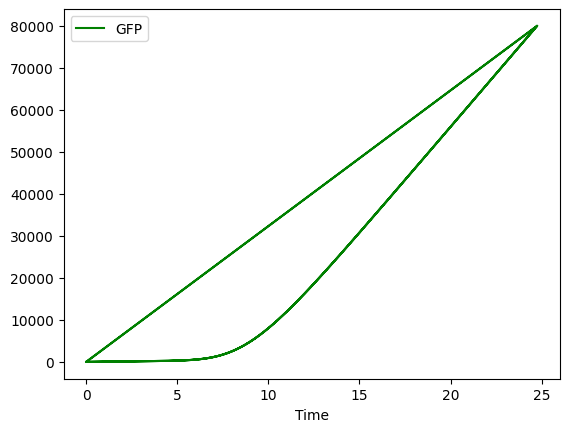

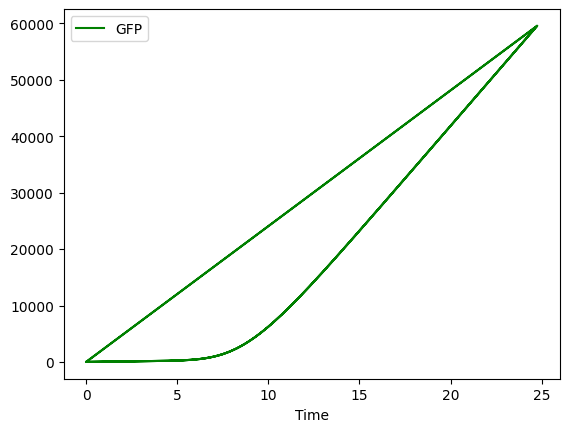

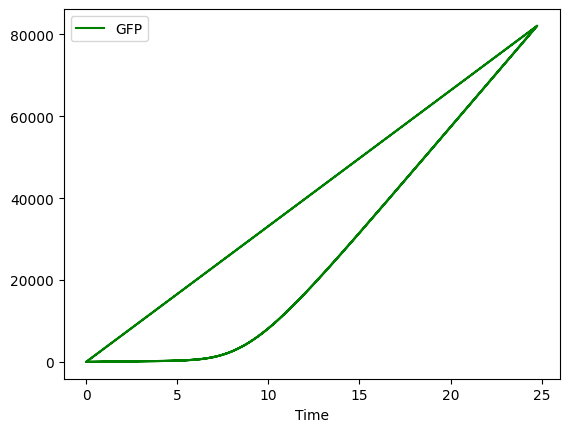

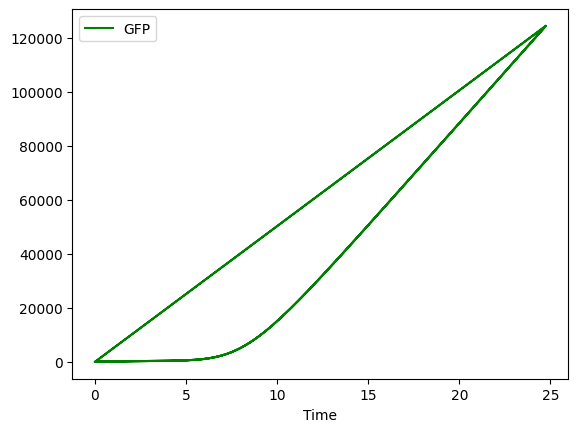

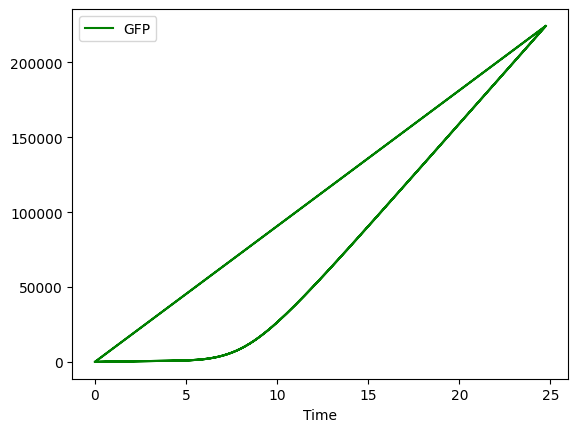

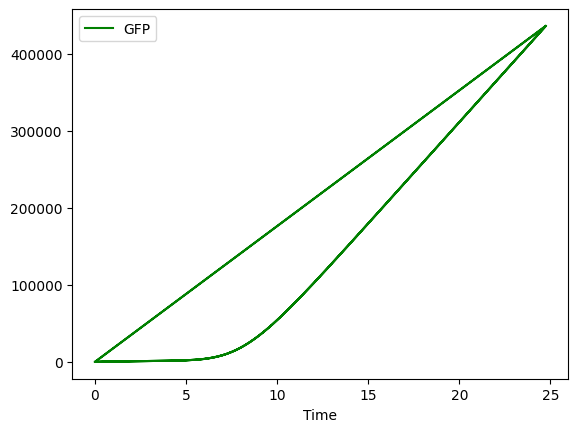

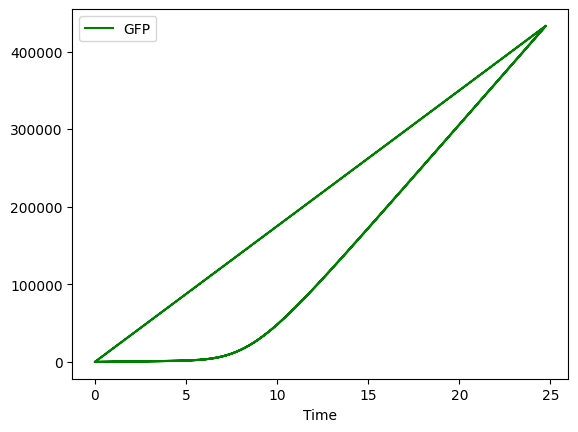

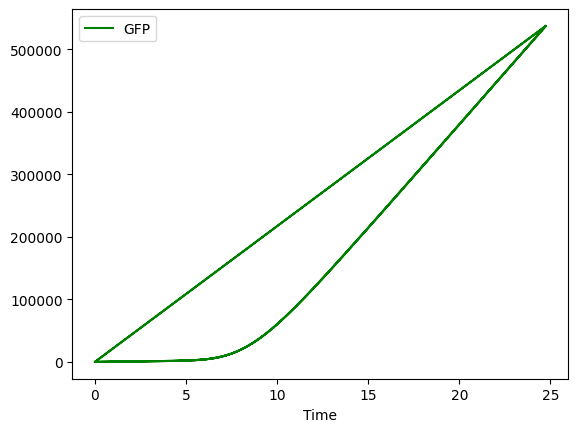

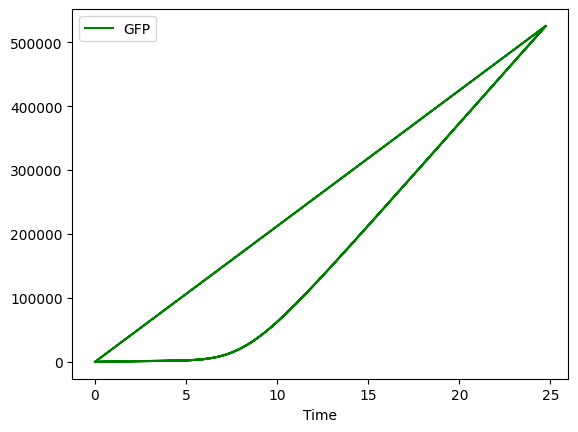

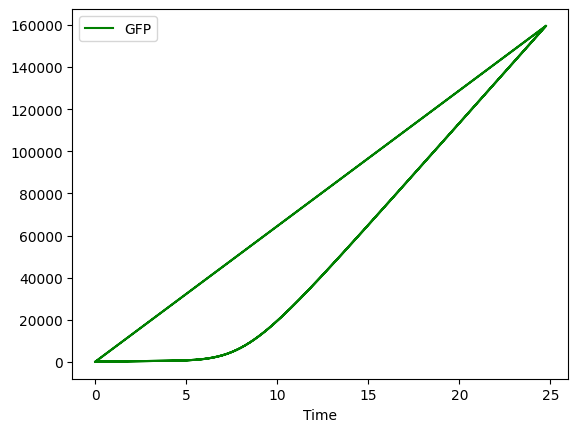

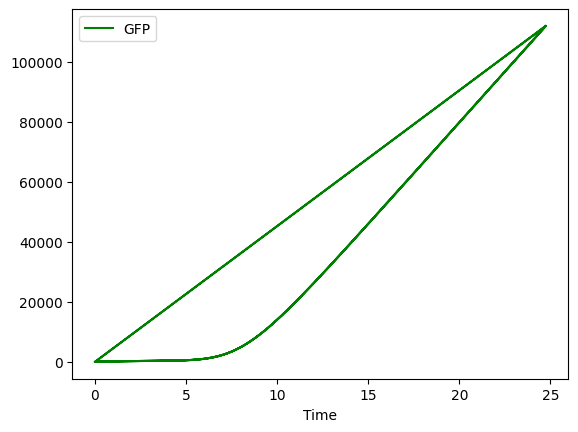

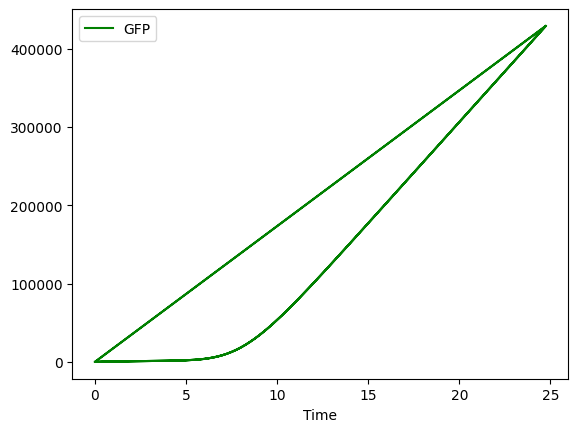

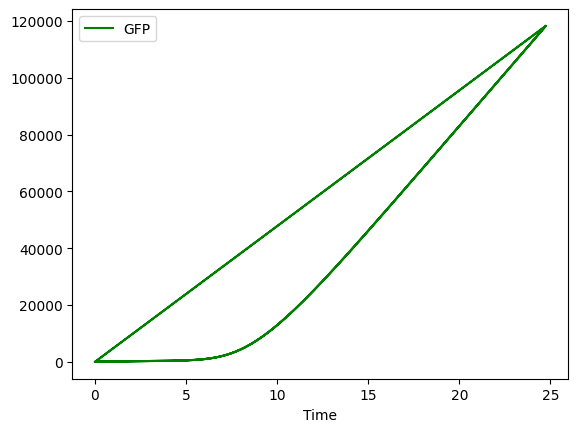

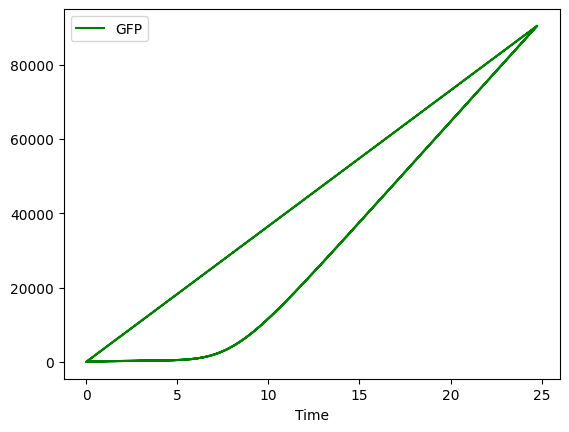

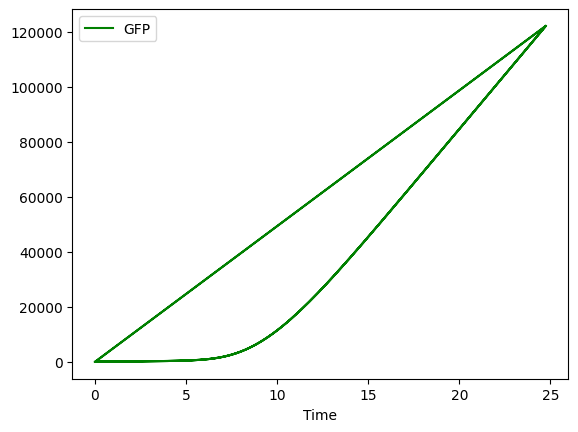

In [44]:
i=0
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 4)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 4)

gfp = lc.Reporter(name='GFP', degradation_rate=0, signal_id=0)

for op in perms:

  rep = lc.GeneticNetwork(vector=0) #add a propoer and identifiable name
  rep.add_regulator([op[0][0],op[1][0], op[2][0]]) #add regulators
  rep.add_reporter(gfp)#[cfp, yfp, rfp]) 
  #build dynamics NOTs, 1000 times to do MEFL
  scalar = 1
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=op[1][0], alpha=[op[0][1]*scalar,op[0][2]]*scalar, K=op[0][3]*scalar, n=op[0][4]),
                     lc.Hill1(input=op[1][0], output=op[2][0], alpha=[op[1][1]*scalar,op[1][2]]*scalar, K=op[1][3]*scalar, n=op[1][4]),
                     lc.Hill1(input=op[2][0], output=op[0][0], alpha=[op[2][1]*scalar,op[2][2]]*scalar, K=op[2][3]*scalar, n=op[2][4])
                     ])
 
  #build reporter NOTs
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=gfp, alpha=[op[0][1]*scalar,op[0][2]]*scalar, K=op[0][3]*scalar, n=op[0][4]),
                     #lc.Hill1(input=op[1][0], output=yfp, alpha=[op[1][1]*scalar,op[1][2]]*scalar, K=op[1][3]*scalar, n=op[1][4]),
                     #lc.Hill1(input=op[2][0], output=rfp, alpha=[op[2][1]*scalar,op[2][2]]*scalar, K=op[2][3]*scalar, n=op[2][4])
                     ])
  
  #AS
  metab = lc.SimulatedMetabolism('SimMetab',biomass, growth_rate)

  samples = []
  # Create 3 replicate samples for simulation
  for _ in range(3):
      sample = lc.Sample(genetic_network=rep, 
                      metabolism=metab)
      samples.append(sample)

  assay = lc.Assay(samples, 
              n_measurements=100, 
              interval=0.25,
              name='Loica repressilator',
              description='Simulated repressilator generated by loica',
              biomass_signal_id=0
             )
  assay.run()
  m = assay.measurements
  fig,ax = plt.subplots(1,1)
  m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
  plt.savefig(f'LOICARepressilator{i}.png', dpi=300)
  i+=1
  

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100.0/100 [00:01<00:00, 73.26it/s]
100%|██████████| 100.0/100 [00:01<00:00, 90.27it/s]
100%|██████████| 100.0/100 [00:01<00:00, 88.37it/s]
100%|██████████| 100.0/100 [00:01<00:00, 78.13it/s]
100%|██████████| 100.0/100 [00:01<00:00, 78.39it/s]
100%|██████████| 100.0/100 [00:01<00:00, 86.56it/s]
100%|██████████| 100.0/100 [00:01<00:00, 91.33it/s]
100%|██████████| 100.0/100 [00:01<00:00, 83.23it/s]
100%|██████████| 100.0/100 [00:01<00:00, 79.22it/s]
100%|██████████| 100.0/100 [00:01<00:00, 93.95it/s]
100%|██████████| 100.0/100 [00:01<00:00, 84.47it/s]
100%|██████████| 100.0/100 [00:01<00:00, 89.70it/s]
100%|██████████| 100.0/100 [00:01<00:00, 86.86it/s]
100%|██████████| 100.0/100 [00:01<00:00, 86.90it/s]
100%|██████████| 100.0/100 [00:01<00:00, 92.71it/s]
100%|██████████| 100.0/100 [00:01<00:00, 97.05it/s]
100%|██████████| 100.0/100 [00:01<00:00, 73.03it/s]
100%|██████████| 100.0/100 [00:01<00:00, 85.50it/s]
100%|██████████| 100.0/100 [00:01<00:00, 58.08it/s]
100%|███████

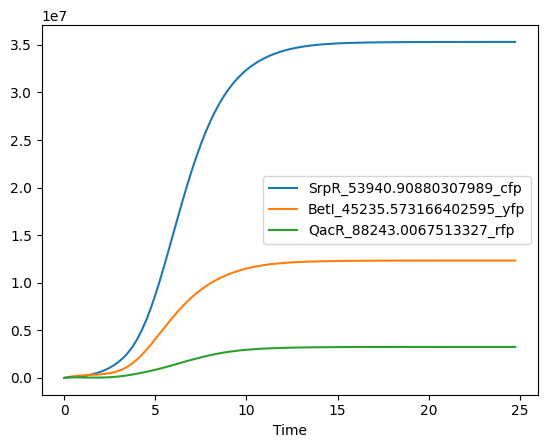

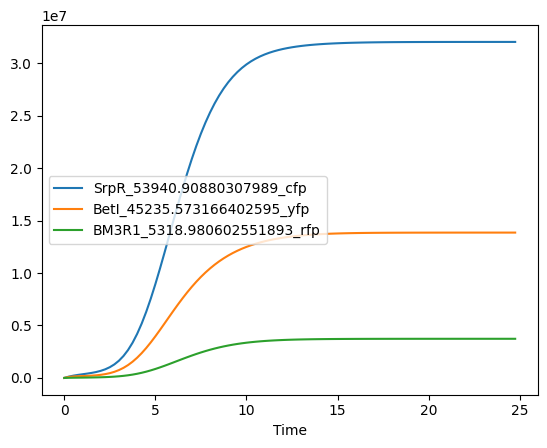

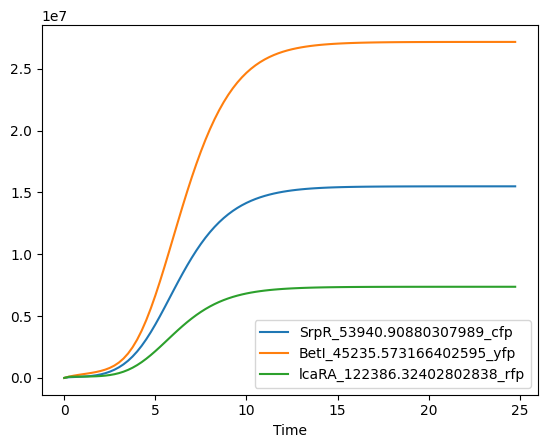

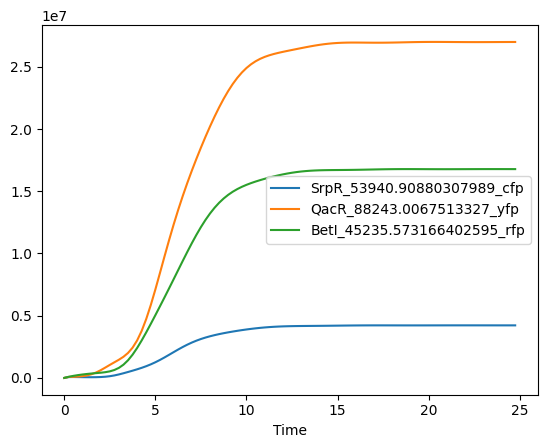

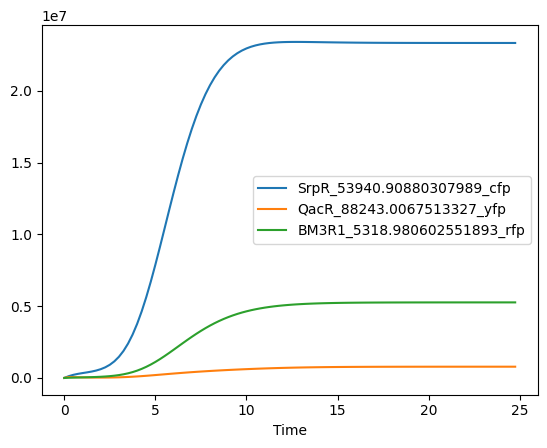

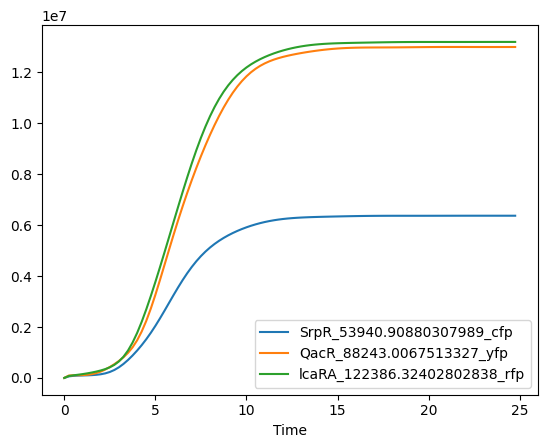

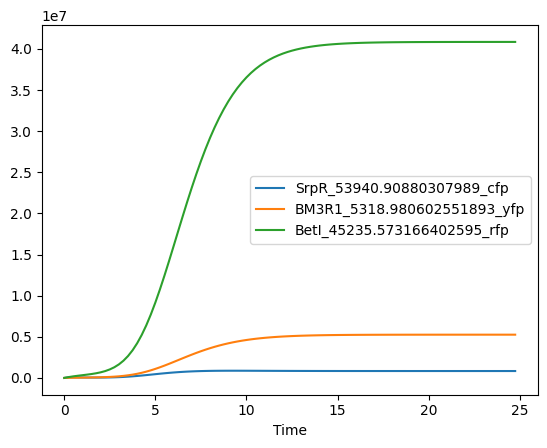

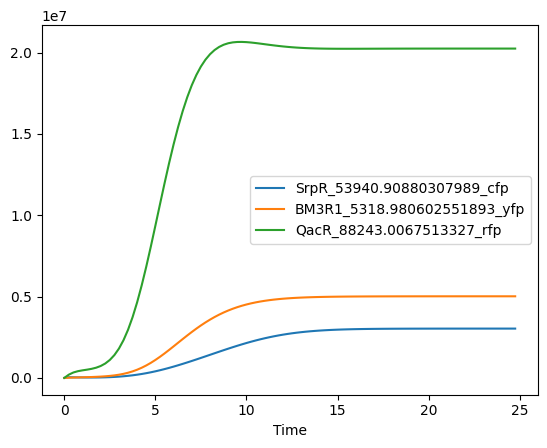

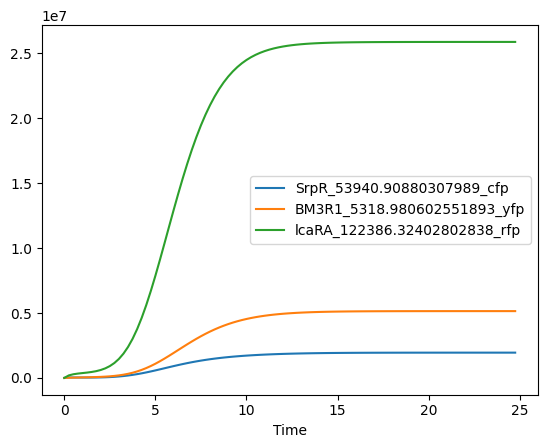

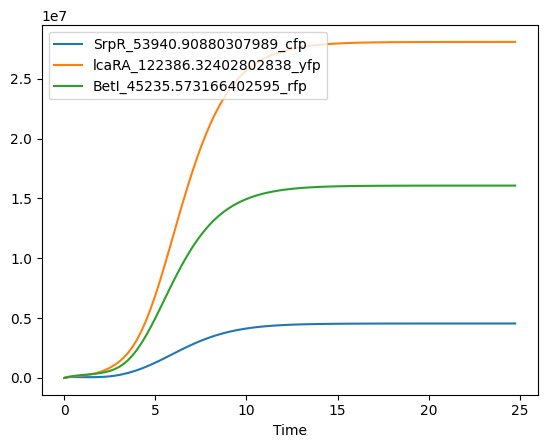

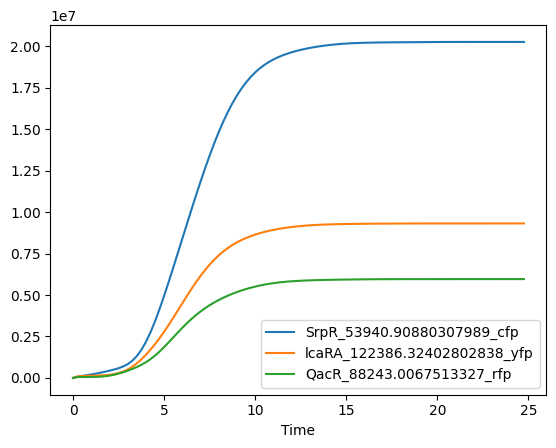

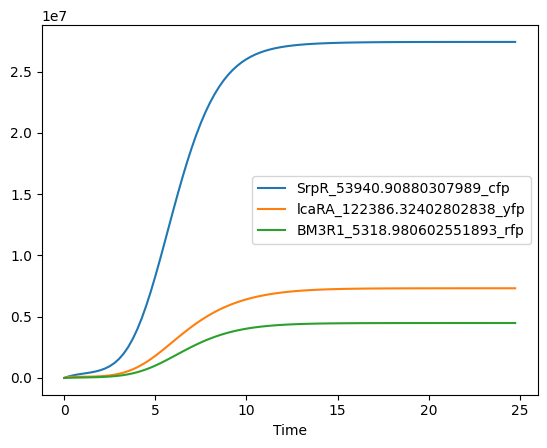

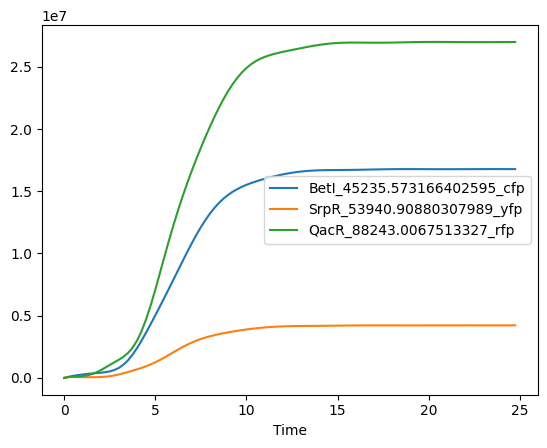

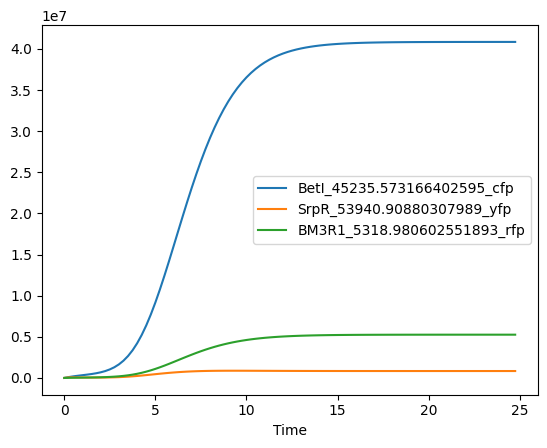

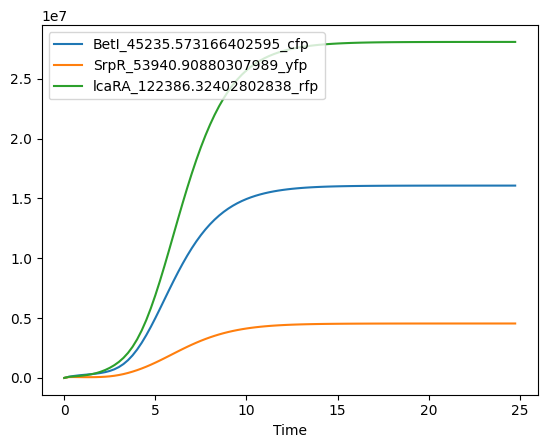

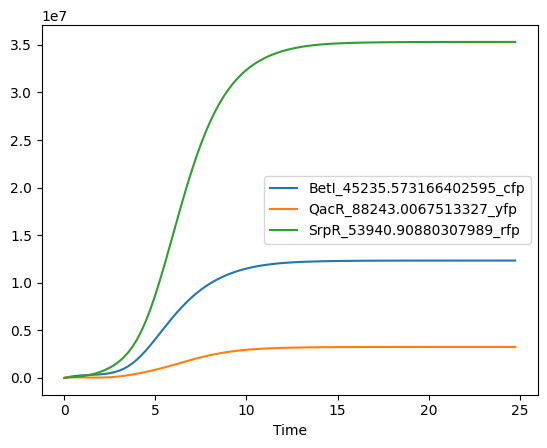

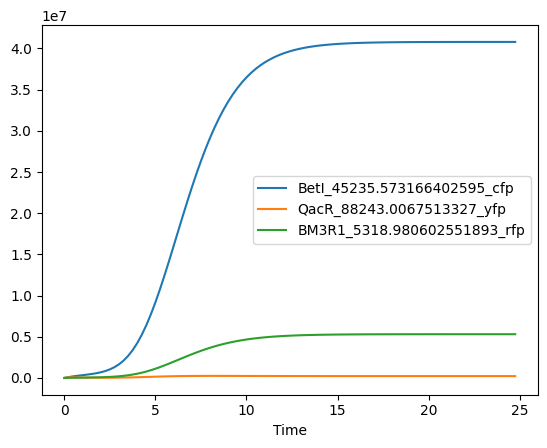

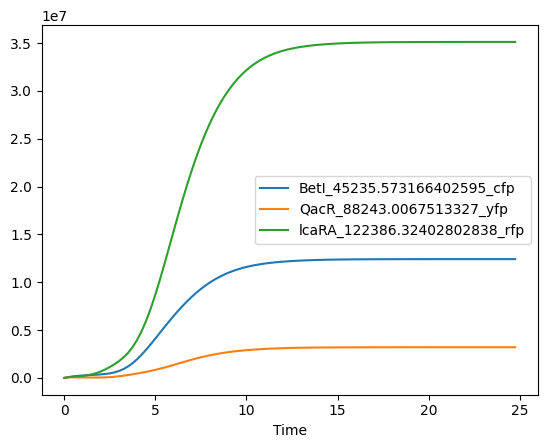

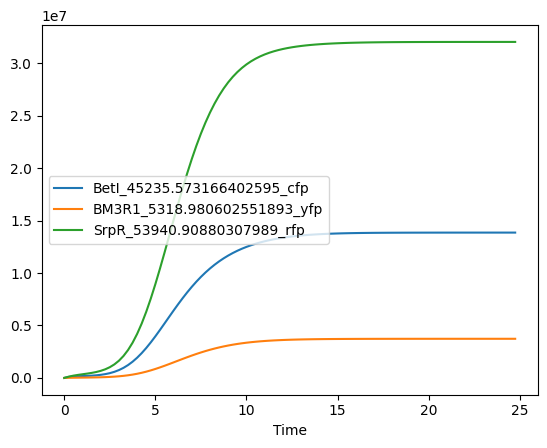

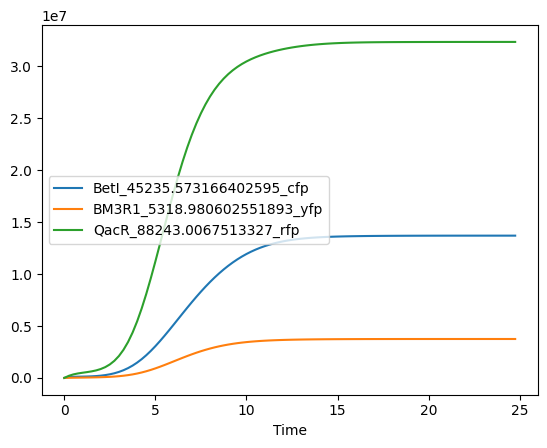

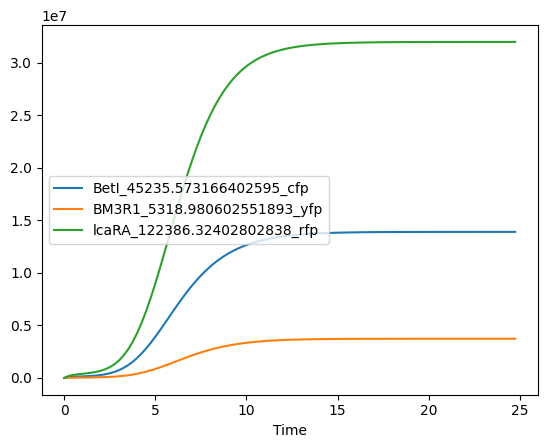

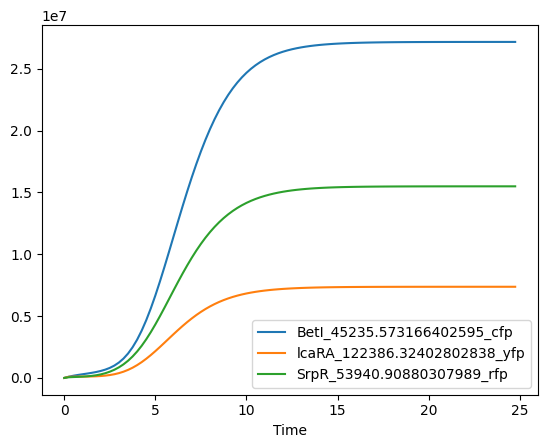

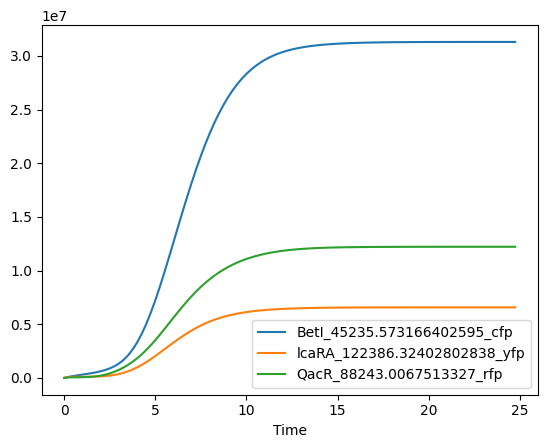

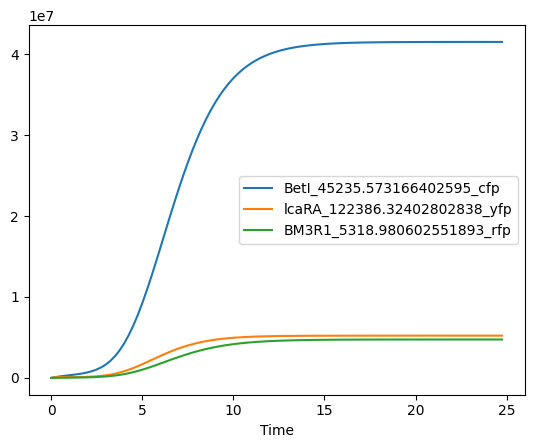

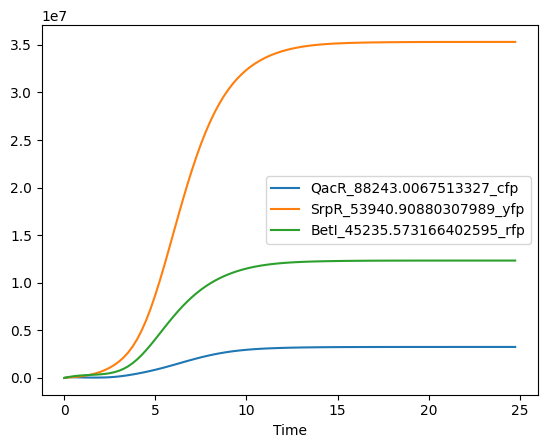

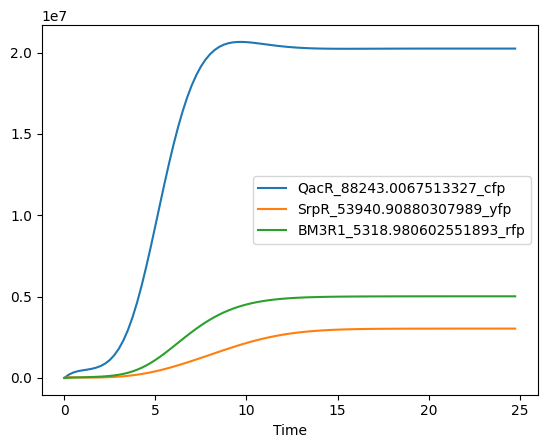

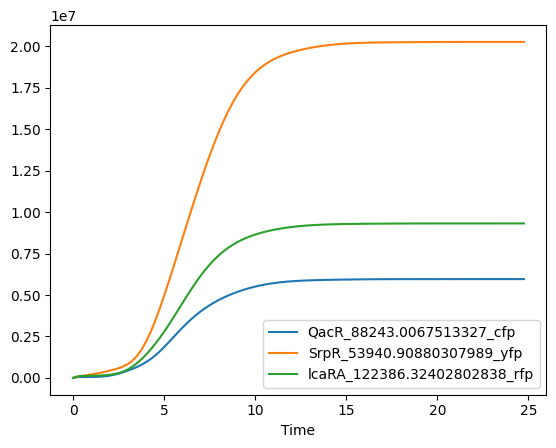

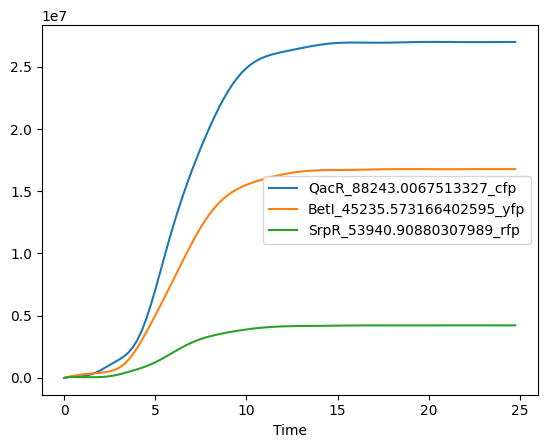

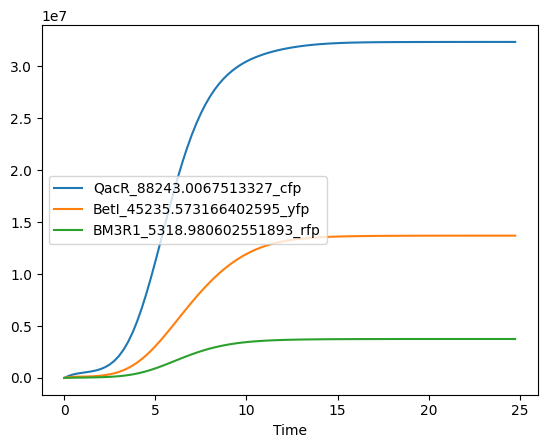

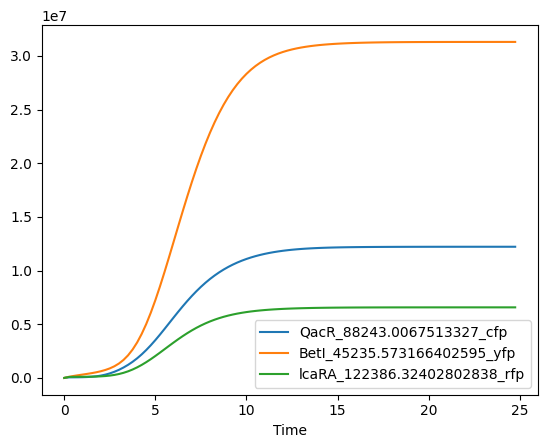

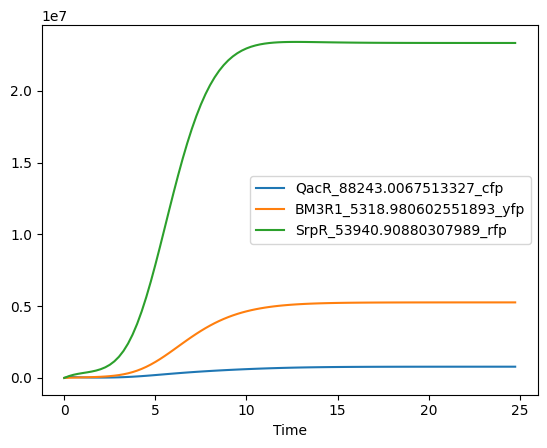

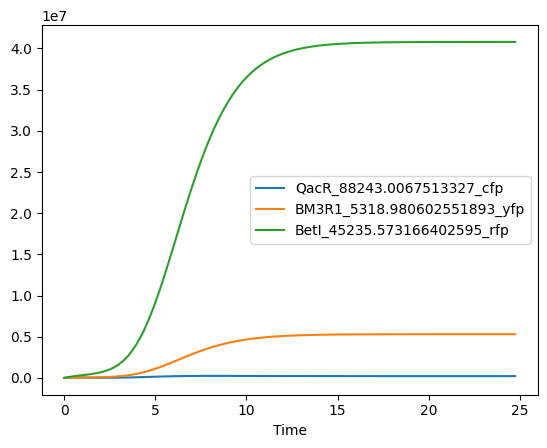

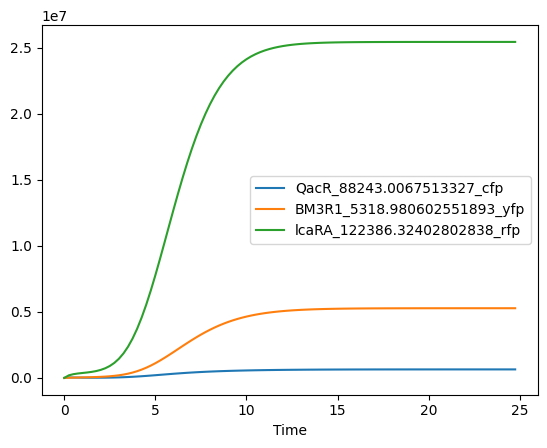

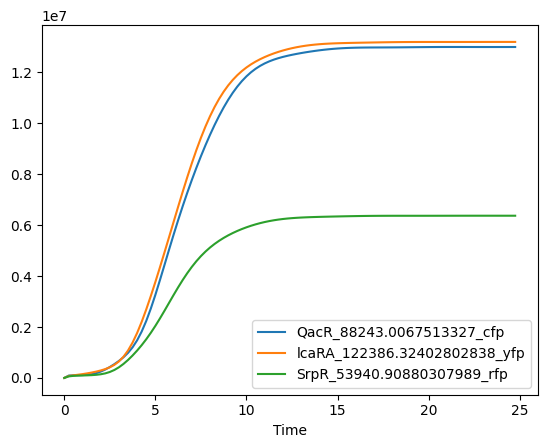

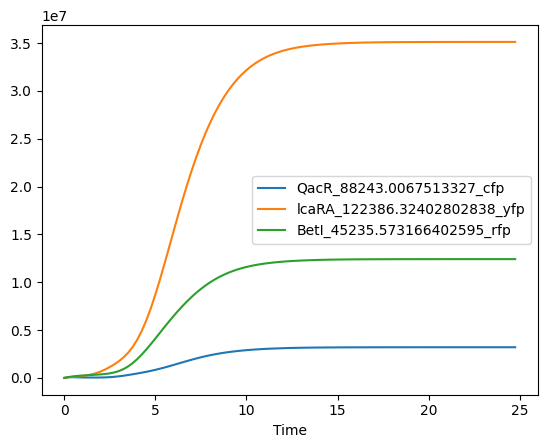

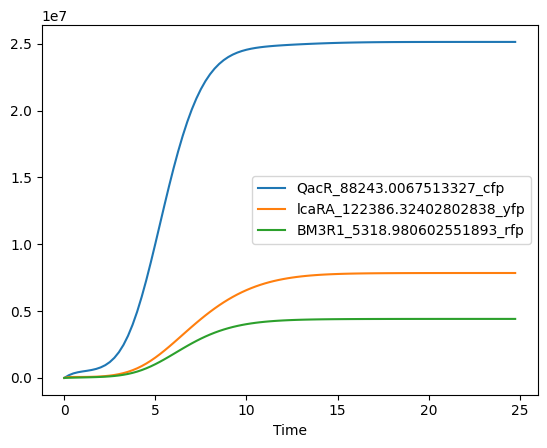

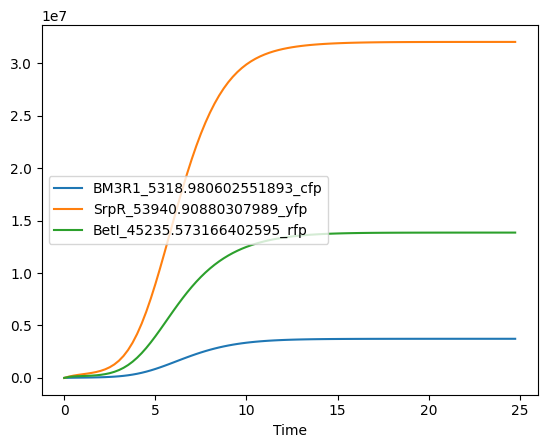

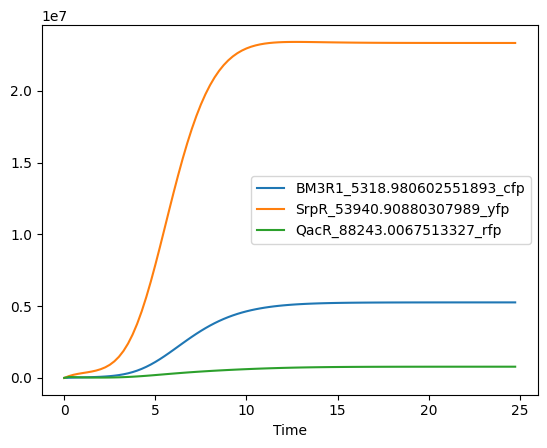

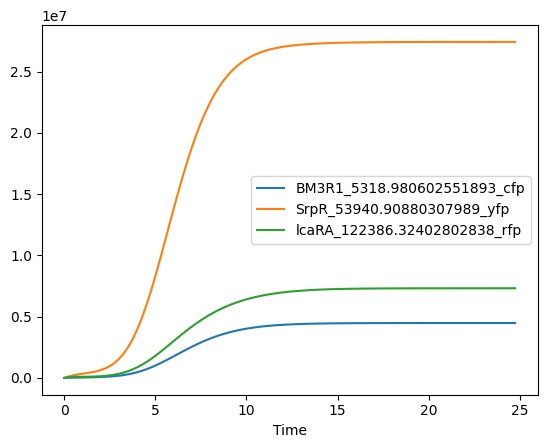

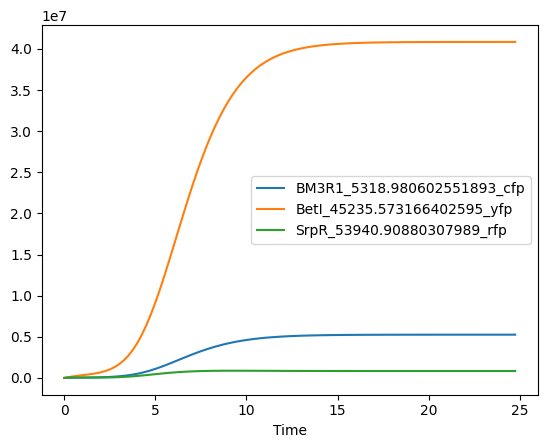

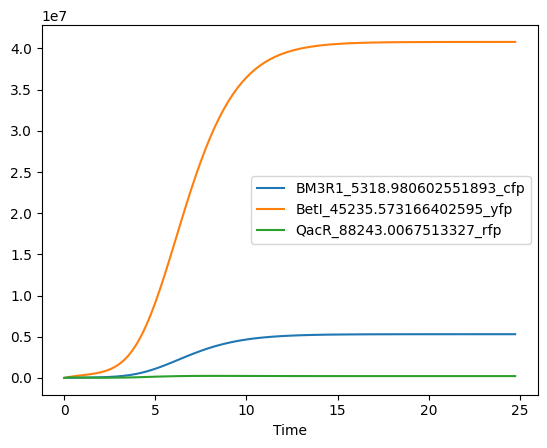

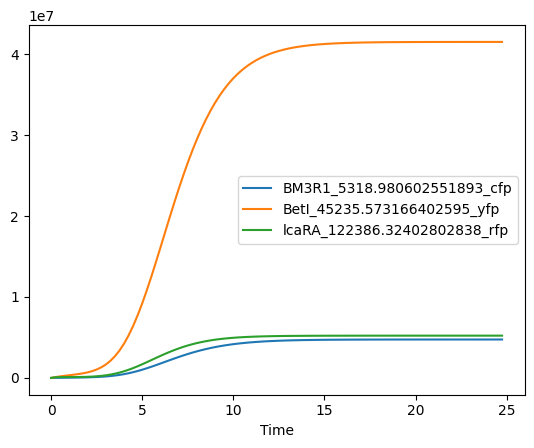

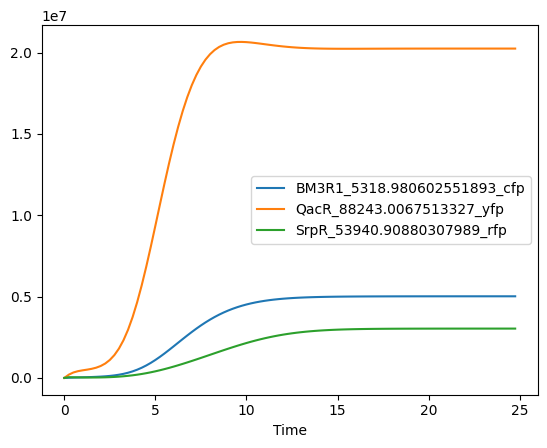

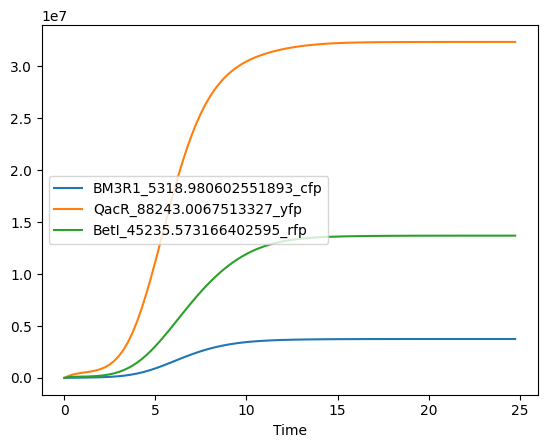

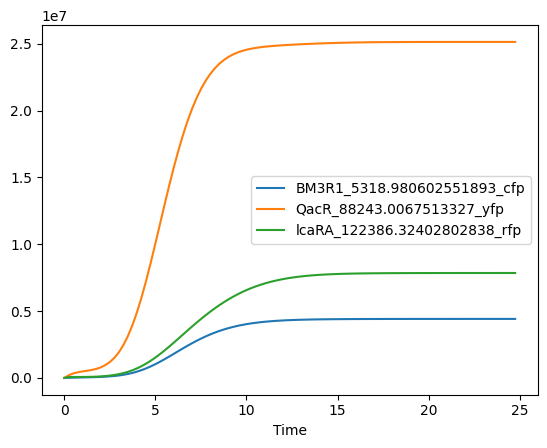

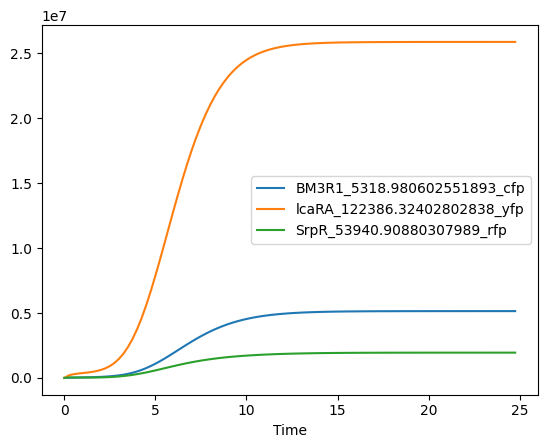

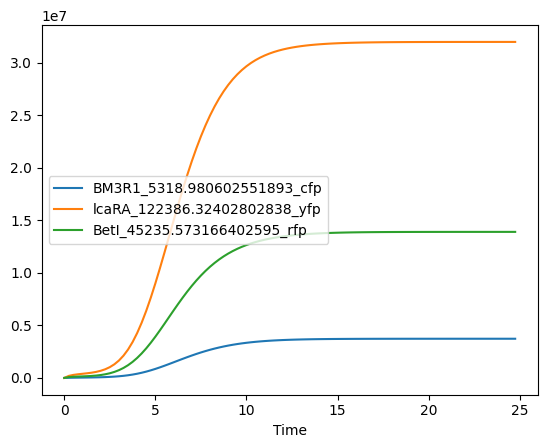

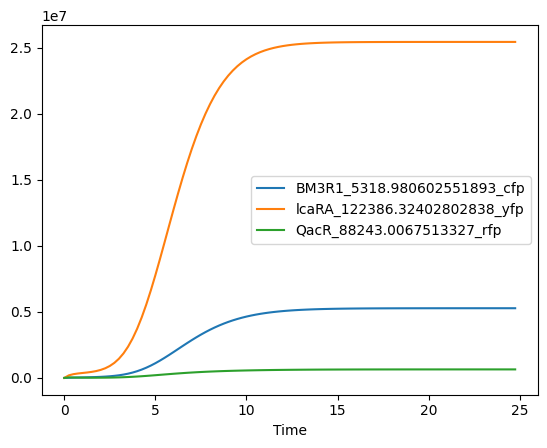

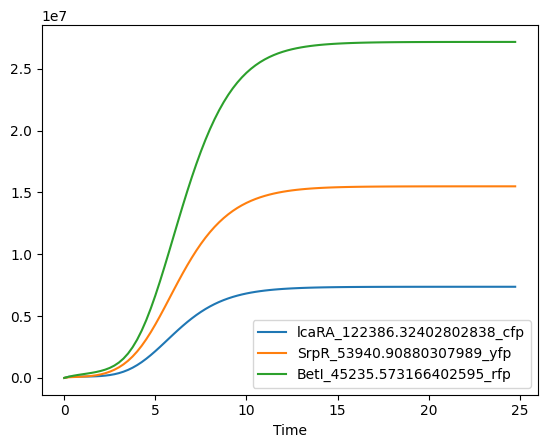

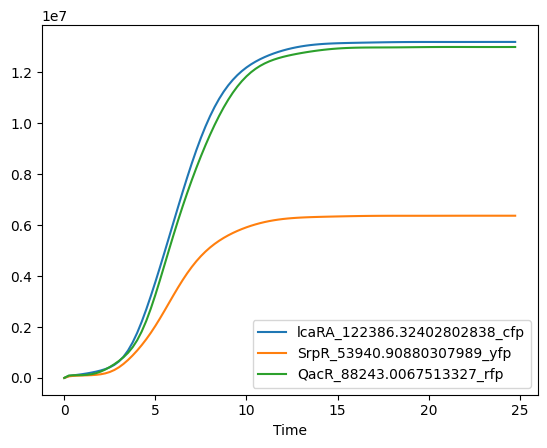

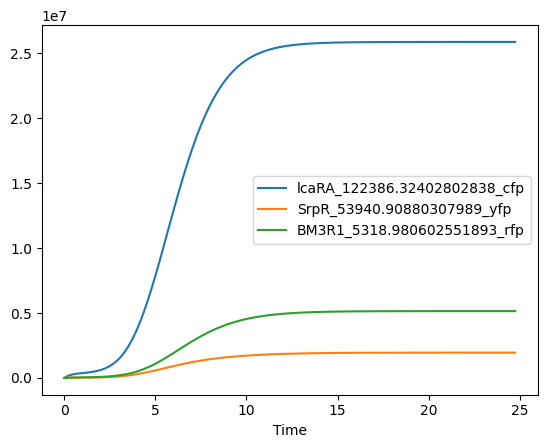

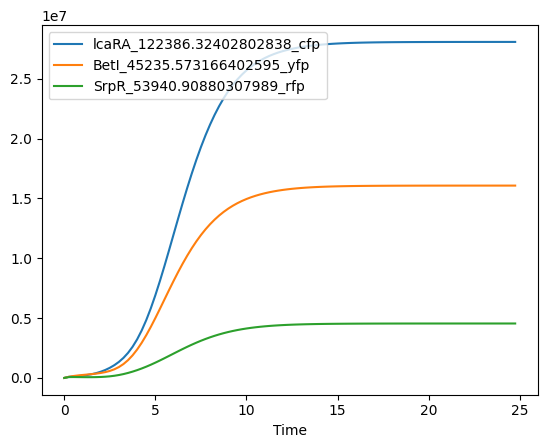

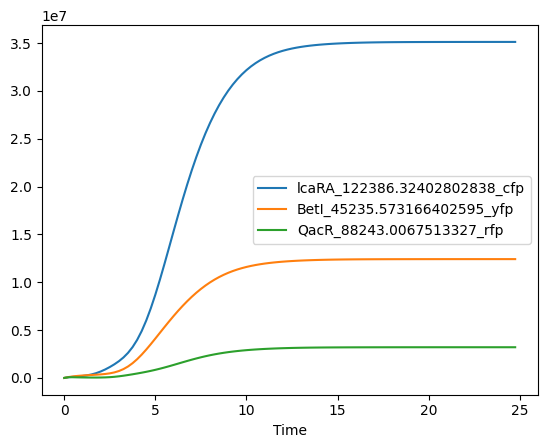

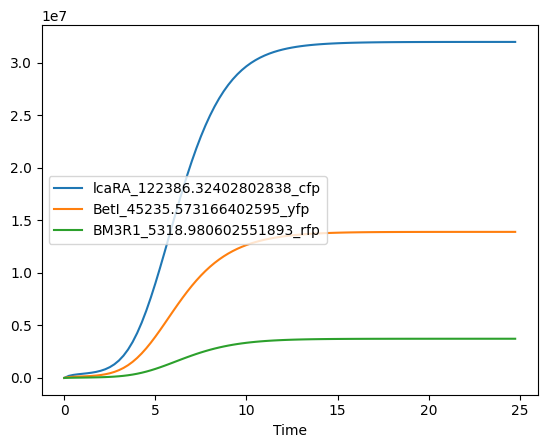

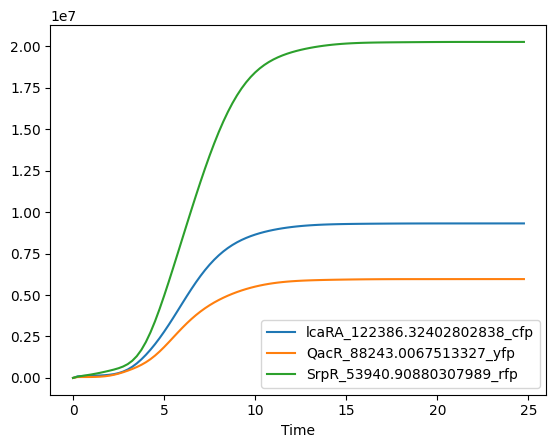

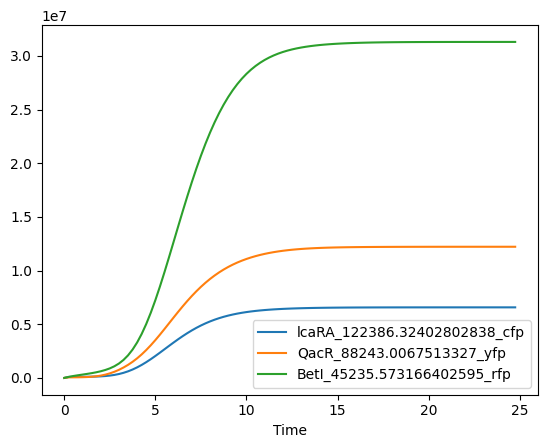

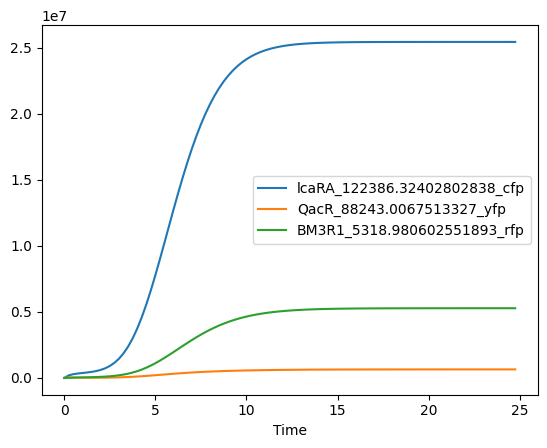

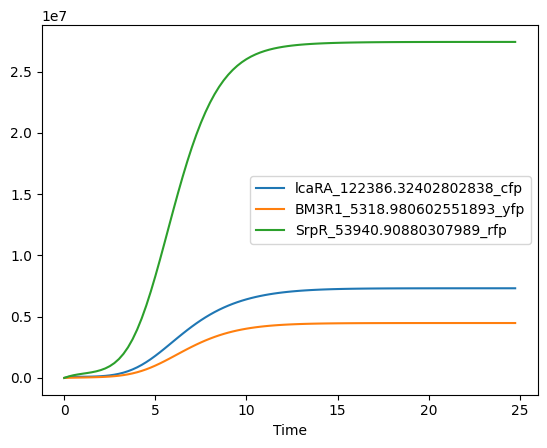

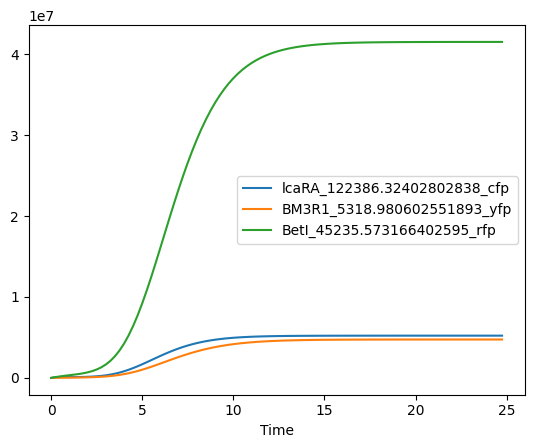

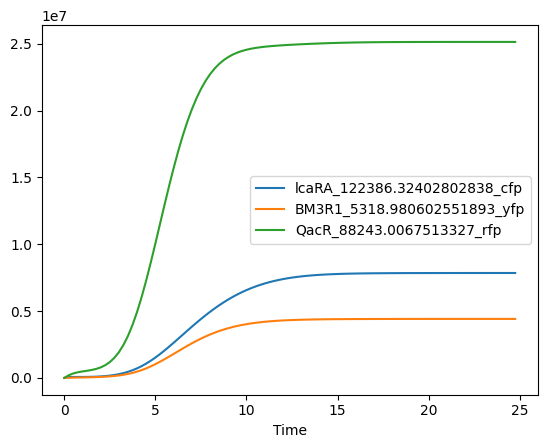

In [46]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

#Create the main df that will contain all the generated data
columns = {'Measurement':[], 'Sample':[], 'Signal':[], 'Signal_id':[], 'Time':[]}
repgen_df = pd.DataFrame(columns)

#build reporters
cfp = lc.Reporter(name='CFP', degradation_rate=1, signal_id=0)
yfp = lc.Reporter(name='YFP', degradation_rate=1, signal_id=0)
rfp = lc.Reporter(name='RFP', degradation_rate=1, signal_id=0)


for op in perms:
  #GNC
  rep = lc.GeneticNetwork(vector=0) #add a propoer and identifiable name
  rep.add_regulator([op[0][0],op[1][0], op[2][0]]) #add regulators
  rep.add_reporter([cfp, yfp, rfp]) 
  #build dynamics NOTs, 1000 times to do MEFL
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=op[1][0], alpha=[op[0][1]*1000,op[0][2]]*1000, K=op[0][3]*1000, n=op[0][4]),
                     lc.Hill1(input=op[1][0], output=op[2][0], alpha=[op[1][1]*1000,op[1][2]]*1000, K=op[1][3]*1000, n=op[1][4]),
                     lc.Hill1(input=op[2][0], output=op[0][0], alpha=[op[2][1]*1000,op[2][2]]*1000, K=op[2][3]*1000, n=op[2][4])
                     ])
 
  #build reporter NOTs
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=cfp, alpha=[op[0][1]*1000,op[0][2]]*1000, K=op[0][3]*1000, n=op[0][4]),
                     lc.Hill1(input=op[1][0], output=yfp, alpha=[op[1][1]*1000,op[1][2]]*1000, K=op[1][3]*1000, n=op[1][4]),
                     lc.Hill1(input=op[2][0], output=rfp, alpha=[op[2][1]*1000,op[2][2]]*1000, K=op[2][3]*1000, n=op[2][4])
                     ])
  
  #AS
  metab = lc.SimulatedMetabolism('SimMetab',biomass, growth_rate)

  sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=0,
                strain=0
               )
  assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='Loica repressilator',
              description='Simulated repressilator generated by loica',
              biomass_signal_id=0
             )
  assay.run()
  assay.measurements['Sample'] = f'rg_{op[0][0]}_{op[1][0]}_{op[2][0]}'
  repgen_df = repgen_df.append(assay.measurements, ignore_index=True)
  m = assay.measurements
  fig,ax = plt.subplots(1,1)
  m[m.Signal=='CFP'].plot(x='Time', y='Measurement', ax=ax, label=f'{op[0][0]}_{op[0][1]}_cfp')
  m[m.Signal=='YFP'].plot(x='Time', y='Measurement', ax=ax, label=f'{op[1][0]}_{op[1][1]}_yfp')
  m[m.Signal=='RFP'].plot(x='Time', y='Measurement', ax=ax, label=f'{op[2][0]}_{op[2][1]}_rfp')
  plt.savefig(f'LOICARepressilator_{op[0][0]}_{op[1][0]}_{op[2][0]}.png', dpi=300)